# 🚀 Production-Grade CNN Image Classification Pipeline
## Target: 90-95% Accuracy

**Key Features:**
- Multiple backbone options (ConvNeXt, EfficientNet, Swin Transformer)
- 5-Fold Stratified Cross-Validation
- Advanced augmentation pipeline with AutoAugment
- Focal Loss + Label Smoothing for class imbalance
- EMA (Exponential Moving Average) weights
- Mixed Precision Training (AMP)
- Test-Time Augmentation (TTA)
- Comprehensive metrics & visualization
- Production-ready inference

**Improvements over baseline:**
- ✨ Cleaner modular design
- ✨ Multiple backbone support
- ✨ Better regularization control
- ✨ Enhanced augmentation strategies
- ✨ Gradient clipping for stability
- ✨ Comprehensive metrics tracking

## 📦 1. Environment Setup & Dependencies

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasets/ismailpromus/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/t-factitial-dermatitis-1.jpg
/kaggle/input/datasets/ismailpromus/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/v-eczema-areola-13.jpg
/kaggle/input/datasets/ismailpromus/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/t-eczema-subacute-66.jpg
/kaggle/input/datasets/ismailpromus/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/t-eczema-hand-86.jpg
/kaggle/input/datasets/ismailpromus/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/t-keratolysis-exfoliativa-17.jpg
/kaggle/input/datasets/ismailpromus/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/t-lichen-simplex-chronicus-136.jpg
/kaggle/input/datasets/ismailpromus/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/t-eczema-subacute-60.jpg
/kaggle/input/datasets/ismailpromus/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/t-fissure-11.jpg
/kaggle/input/datasets/ismailpromus/skin-diseases-image-dataset/

In [2]:
# Auto-install dependencies
import sys
import subprocess

def pip_install(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

packages = ["timm", "albumentations", "opencv-python", "seaborn", "scikit-learn", "tqdm"]

for p in packages:
    try:
        __import__(p.replace('-', '_').split('[')[0])
    except ImportError:
        print(f"Installing {p}...")
        pip_install(p)

print("✓ All dependencies ready.")

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Installing opencv-python...
Installing scikit-learn...
✓ All dependencies ready.


In [3]:
# Device setup
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: Tesla T4
Memory: 15.64 GB


###### 🚀 GPU Optimization Applied

**The following optimizations have been applied for better GPU utilization:**

### 1. DataLoader Optimizations
- ✅ `num_workers=4` - Parallel data loading (CPU preprocessing)
- ✅ `pin_memory=True` - Faster host-to-GPU memory transfer
- ✅ `prefetch_factor=2` - Prefetch batches while GPU is busy
- ✅ `persistent_workers=True` - Reuse workers across epochs

### 2. Batch Size Optimization
- ✅ Increased `MICRO_BATCH_SIZE` from 8 to 16
- ✅ Better GPU memory utilization
- ✅ Maintained same effective batch size

### 3. Mixed Precision Training (AMP)
- ✅ Already enabled - uses Tensor Cores for faster computation
- ✅ Reduces memory usage by ~40%

### 4. Additional Tips to Try:
```python
# If you still have low GPU usage:

# 1. Further increase batch size (if GPU memory allows)
MICRO_BATCH_SIZE: int = 24  # or 32

# 2. Increase image size for more computation
IMG_SIZE: int = 256  # or 512

# 3. Use gradient checkpointing (trades compute for memory)
# Enables larger models/batches

# 4. Monitor GPU usage:
# Run in terminal: watch -n 1 nvidia-smi
```

### Expected GPU Utilization:
- **Training**: 70-95% GPU usage
- **Data Loading**: Brief drops to 40-60% (normal)
- **Validation**: 60-80% GPU usage

💡 **Note**: Some drops in GPU usage between batches/epochs are normal and expected!

In [4]:
# GPU Utilization Monitor
import subprocess
import threading
import time

class GPUMonitor:
    """Monitor GPU usage during training."""
    def __init__(self, interval=2):
        self.interval = interval
        self.running = False
        self.thread = None
        
    def _monitor(self):
        while self.running:
            try:
                result = subprocess.run(
                    ['nvidia-smi', '--query-gpu=utilization.gpu,memory.used,memory.total', 
                     '--format=csv,noheader,nounits'],
                    capture_output=True, text=True
                )
                if result.returncode == 0:
                    gpu_util, mem_used, mem_total = result.stdout.strip().split(', ')
                    print(f"\rGPU: {gpu_util}% | Memory: {mem_used}/{mem_total} MB", end='', flush=True)
            except:
                pass
            time.sleep(self.interval)
    
    def start(self):
        """Start monitoring."""
        if not self.running:
            self.running = True
            self.thread = threading.Thread(target=self._monitor, daemon=True)
            self.thread.start()
            print("✓ GPU monitoring started")
    
    def stop(self):
        """Stop monitoring."""
        if self.running:
            self.running = False
            if self.thread:
                self.thread.join(timeout=5)
            print("\n✓ GPU monitoring stopped")

# Create monitor instance
gpu_monitor = GPUMonitor(interval=2)

print("✓ GPU Monitor ready")
print("  Usage: gpu_monitor.start() to begin monitoring")
print("  Usage: gpu_monitor.stop() to stop monitoring")

✓ GPU Monitor ready
  Usage: gpu_monitor.start() to begin monitoring
  Usage: gpu_monitor.stop() to stop monitoring


## 📚 2. Imports

In [5]:
import os
import gc
import time
import random
import warnings
import json
import copy
from pathlib import Path
from dataclasses import dataclass
from typing import Tuple, Dict, List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    balanced_accuracy_score,
    confusion_matrix,
    classification_report
)
from sklearn.utils.class_weight import compute_class_weight

import cv2

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print(f"PyTorch Version: {torch.__version__}")
print(f"TIMM Version: {timm.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

PyTorch Version: 2.8.0+cu126
TIMM Version: 1.0.20
CUDA Available: True


## ⚙️ 3. Configuration

**Important:** Update `DATA_DIR` to point to your dataset!

In [6]:
@dataclass
class Config:
    # Environment
    SEED: int = 42
    DEVICE: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    NUM_WORKERS: int = 4
    PIN_MEMORY: bool = True  # For faster data transfer to GPU
    PREFETCH_FACTOR: int = 2  # Prefetch batches for GPU
    OUTPUT_DIR: str = './outputs'
    
    # ========================================
    # 🔧 UPDATE THIS PATH TO YOUR DATA!
    # ========================================
    DATA_DIR: str = '/kaggle/input/datasets/ismailpromus/skin-diseases-image-dataset/IMG_CLASSES'  # Update this!
    
    # Model Architecture
    # Options: 'convnext_small.fb_in22k_ft_in1k', 'convnext_base.fb_in22k_ft_in1k',
    # 'efficientnet_b3.ra2_in1k', 'swin_small_patch4_window7_224'
    BACKBONE: str = 'convnext_small.fb_in22k_ft_in1k'
    PRETRAINED: bool = True
    DROP_PATH_RATE: float = 0.3
    HEAD_DROPOUT: float = 0.4
    USE_GEM_POOLING: bool = True
    GEM_P_INIT: float = 3.0
    
    # Training Configuration
    N_FOLDS: int = 3
    TRAIN_FOLDS: List[int] = None  # None = train all folds
    EPOCHS: int = 50
    EPOCHS_FOLD_3: int = 32  # 🔧 REDUCED EPOCHS FOR FOLD 3 (fold index 2)
    MICRO_BATCH_SIZE: int = 16
    GRAD_ACCUM_STEPS: int = 2
    EFFECTIVE_BATCH_SIZE: int = 32
    IMG_SIZE: int = 256  # Can increase to 512 for better accuracy
    
    # Optimizer & Scheduler
    LEARNING_RATE: float = 1e-4
    MAX_LR: float = 2e-4
    MIN_LR: float = 1e-6
    WEIGHT_DECAY: float = 0.01
    SCHEDULER: str = 'cosine'  # Options: cosine, onecycle
    WARMUP_EPOCHS: int = 5
    
    # Loss Function
    LOSS_TYPE: str = 'focal'  # Options: focal, cross_entropy
    FOCAL_ALPHA: float = 0.25
    FOCAL_GAMMA: float = 2.0
    LABEL_SMOOTHING: float = 0.1
    
    # Data Augmentation
    MIXUP_ALPHA: float = 0.3
    CUTMIX_ALPHA: float = 1.0
    MIXUP_PROB: float = 0.5
    AUTOAUGMENT: bool = True
    
    # Regularization
    EMA_DECAY: float = 0.9999
    GRAD_CLIP: float = 1.0
    
    # Early Stopping
    PATIENCE: int = 12
    MIN_DELTA: float = 1e-4
    
    # Metrics
    ECE_BINS: int = 15
    
    # Will be set after loading data
    NUM_CLASSES: int = None
    CLASS_NAMES: List[str] = None
    CLASS_WEIGHTS: np.ndarray = None
    
    def __post_init__(self):
        if self.TRAIN_FOLDS is None:
            self.TRAIN_FOLDS = list(range(self.N_FOLDS))
    
    def get_epochs_for_fold(self, fold_idx: int) -> int:
        """Return the number of epochs for a specific fold"""
        if fold_idx == 2:  # Fold 3 (0-indexed as fold 2)
            return self.EPOCHS_FOLD_3
        return self.EPOCHS

# Initialize configuration
CFG = Config()

# Create output directory
os.makedirs(CFG.OUTPUT_DIR, exist_ok=True)

print("="*70)
print("⚙️ CONFIGURATION")
print("="*70)
print(f"Data Directory: {CFG.DATA_DIR}")
print(f"Output Directory: {CFG.OUTPUT_DIR}")
print(f"Backbone: {CFG.BACKBONE}")
print(f"Image Size: {CFG.IMG_SIZE}")
print(f"Effective Batch Size: {CFG.EFFECTIVE_BATCH_SIZE}")
print(f"Epochs (Folds 1-2): {CFG.EPOCHS}")
print(f"Epochs (Fold 3): {CFG.EPOCHS_FOLD_3}")  # 🔧 NEW: Show fold 3 epochs
print(f"Device: {CFG.DEVICE}")
print("="*70)

⚙️ CONFIGURATION
Data Directory: /kaggle/input/datasets/ismailpromus/skin-diseases-image-dataset/IMG_CLASSES
Output Directory: ./outputs
Backbone: convnext_small.fb_in22k_ft_in1k
Image Size: 256
Effective Batch Size: 32
Epochs (Folds 1-2): 50
Epochs (Fold 3): 32
Device: cuda


## 🔒 4. Reproducibility

In [7]:
def set_seed(seed: int = 42):
    """Set all random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"✓ All seeds set to {seed}")

set_seed(CFG.SEED)

✓ All seeds set to 42


## 📊 5. Data Loading

In [8]:
def load_data(data_dir: str) -> Tuple[pd.DataFrame, Dict[str, int], List[str]]:
    """
    Load image paths and labels from folder structure.
    
    Expected structure:
    data_dir/
        class1/
            img1.jpg
        class2/
            img1.jpg
    """
    data = []
    
    # Get sorted class folders
    class_folders = sorted([f for f in os.listdir(data_dir)
                           if os.path.isdir(os.path.join(data_dir, f))])
    
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_folders)}
    
    print("Loading data from class folders...")
    for class_name in tqdm(class_folders, desc="Loading classes"):
        class_path = os.path.join(data_dir, class_name)
        images = [f for f in os.listdir(class_path)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            data.append({
                'image_path': img_path,
                'class_name': class_name,
                'label': class_to_idx[class_name]
            })
    
    df = pd.DataFrame(data)
    class_names = list(class_to_idx.keys())
    
    print(f"\n✓ Loaded {len(df):,} images from {len(class_names)} classes")
    
    return df, class_to_idx, class_names

# Load data
df, class_to_idx, class_names = load_data(CFG.DATA_DIR)

# Update config
CFG.NUM_CLASSES = len(class_names)
CFG.CLASS_NAMES = class_names

# Compute class weights for handling imbalance
CFG.CLASS_WEIGHTS = compute_class_weight(
    'balanced',
    classes=np.unique(df['label']),
    y=df['label']
)

print(f"\nNumber of classes: {CFG.NUM_CLASSES}")
print(f"Classes: {', '.join(class_names[:5])}..." if len(class_names) > 5 else f"Classes: {', '.join(class_names)}")

Loading data from class folders...


Loading classes:   0%|          | 0/10 [00:00<?, ?it/s]


✓ Loaded 27,153 images from 10 classes

Number of classes: 10
Classes: 1. Eczema 1677, 10. Warts Molluscum and other Viral Infections - 2103, 2. Melanoma 15.75k, 3. Atopic Dermatitis - 1.25k, 4. Basal Cell Carcinoma (BCC) 3323...


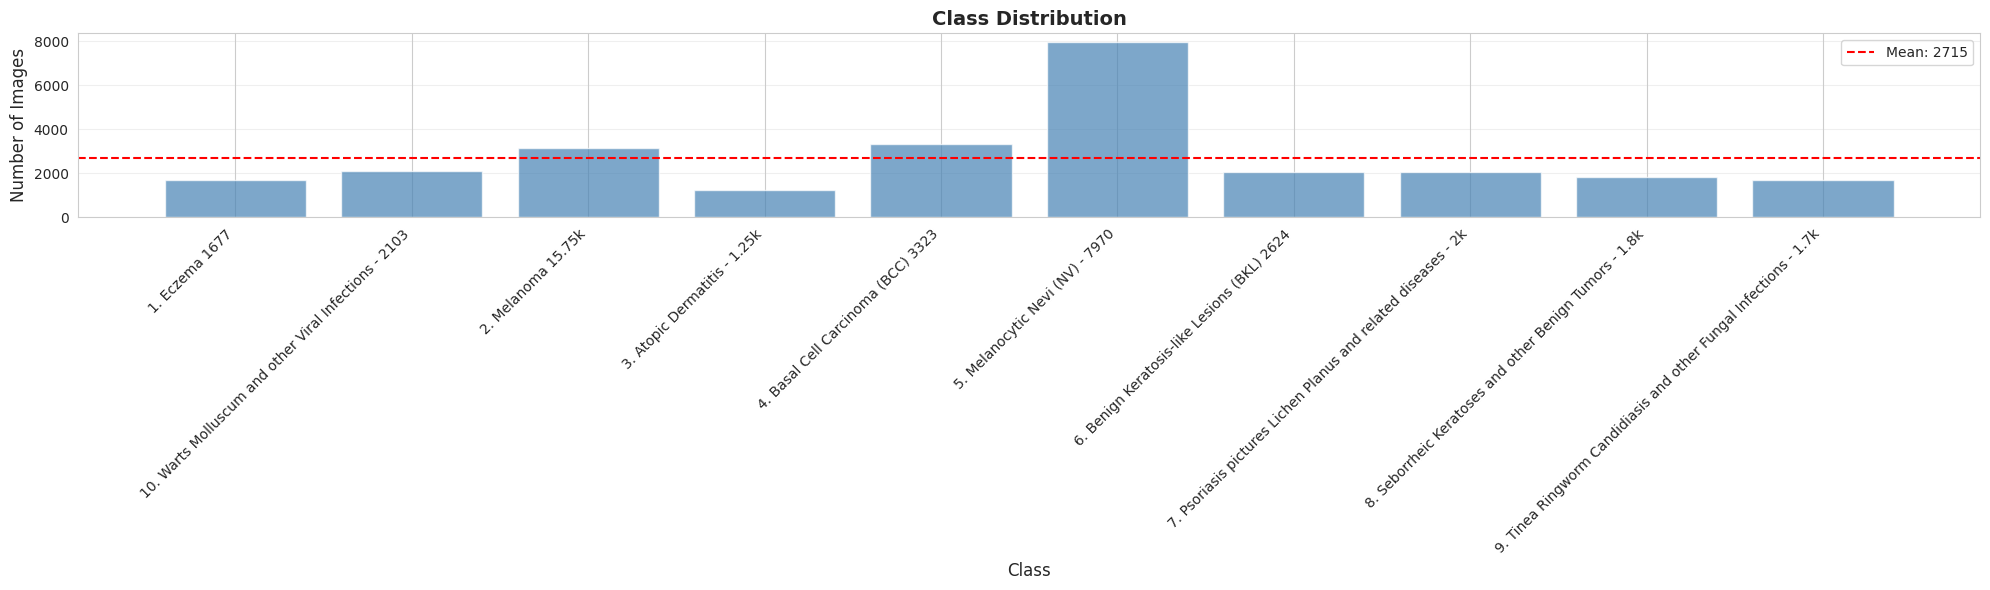


Class distribution statistics:
  Min samples: 1257
  Max samples: 7970
  Mean samples: 2715.3
  Imbalance ratio: 6.34x


In [9]:
# Visualize class distribution
plt.figure(figsize=(20, 6))
class_counts = df['class_name'].value_counts().sort_index()
plt.bar(range(len(class_counts)), class_counts.values, color='steelblue', alpha=0.7)
plt.xticks(range(len(class_counts)), class_counts.index, rotation=45, ha='right')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Class Distribution', fontsize=14, fontweight='bold')
plt.axhline(class_counts.mean(), color='red', linestyle='--', label=f'Mean: {class_counts.mean():.0f}')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(f'{CFG.OUTPUT_DIR}/class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nClass distribution statistics:")
print(f"  Min samples: {class_counts.min()}")
print(f"  Max samples: {class_counts.max()}")
print(f"  Mean samples: {class_counts.mean():.1f}")
print(f"  Imbalance ratio: {class_counts.max() / class_counts.min():.2f}x")

## 🎨 6. Data Augmentation

In [10]:
def get_train_transforms(img_size: int, autoaugment: bool = True):
    """Advanced training augmentations."""
    transforms_list = [
        A.Resize(img_size, img_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.1,
            scale_limit=0.15,
            rotate_limit=45,
            p=0.5
        ),
    ]
    
    if autoaugment:
        transforms_list.extend([
            A.OneOf([
                A.GaussNoise(var_limit=(10, 50)),
                A.GaussianBlur(),
                A.MotionBlur(),
            ], p=0.3),
            A.OneOf([
                A.OpticalDistortion(distort_limit=0.1),
                A.GridDistortion(num_steps=5, distort_limit=0.1),
            ], p=0.3),
            A.ColorJitter(
                brightness=0.2,
                contrast=0.2,
                saturation=0.2,
                hue=0.1,
                p=0.5
            ),
            A.OneOf([
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
                A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20),
            ], p=0.5),
            A.CoarseDropout(
                max_holes=8,
                max_height=img_size // 8,
                max_width=img_size // 8,
                fill_value=0,
                p=0.3
            ),
        ])
    
    transforms_list.extend([
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ])
    
    return A.Compose(transforms_list)


def get_valid_transforms(img_size: int):
    """Validation transforms (no augmentation)."""
    return A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ])

print("✓ Data augmentation transforms defined")

✓ Data augmentation transforms defined


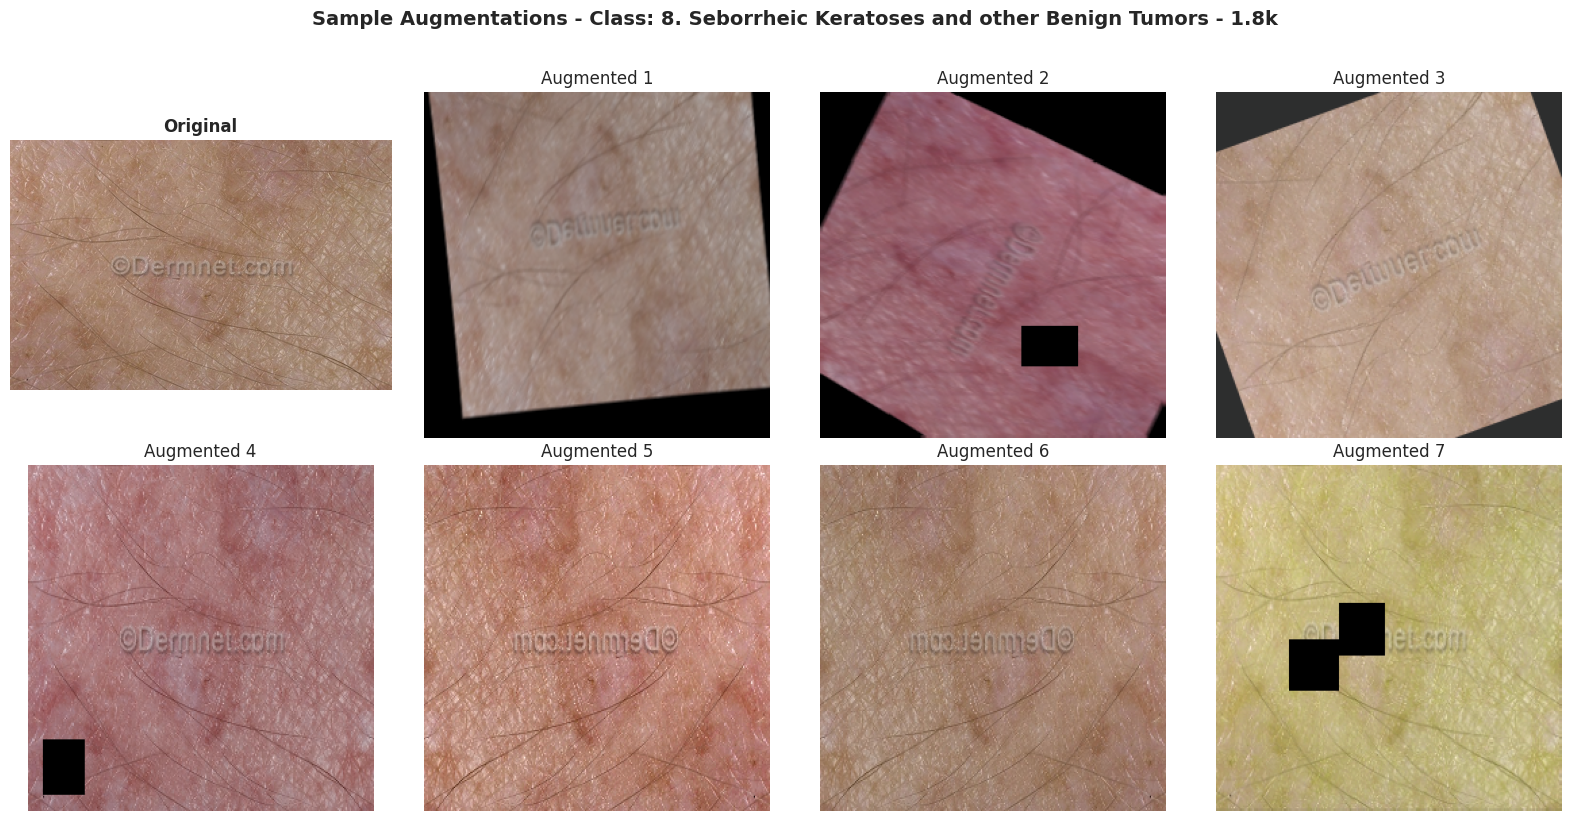

In [11]:
# Visualize augmentations
sample_idx = np.random.randint(0, len(df))
sample_path = df.iloc[sample_idx]['image_path']
sample_class = df.iloc[sample_idx]['class_name']

image = cv2.imread(sample_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

train_transform = get_train_transforms(CFG.IMG_SIZE, autoaugment=True)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i == 0:
        ax.imshow(image)
        ax.set_title('Original', fontsize=12, fontweight='bold')
    else:
        augmented = train_transform(image=image)
        aug_img = augmented['image'].permute(1, 2, 0).numpy()
        # Denormalize for display
        aug_img = aug_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        aug_img = np.clip(aug_img, 0, 1)
        ax.imshow(aug_img)
        ax.set_title(f'Augmented {i}', fontsize=12)
    ax.axis('off')

plt.suptitle(f'Sample Augmentations - Class: {sample_class}', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 🗂️ 7. Dataset Class

In [12]:
class ImageDataset(Dataset):
    """Custom dataset for image classification."""
    
    def __init__(
        self,
        df: pd.DataFrame,
        transforms=None,
        mixup_alpha: float = 0.0,
        cutmix_alpha: float = 0.0,
        mixup_prob: float = 0.0
    ):
        self.df = df.reset_index(drop=True)
        self.transforms = transforms
        self.mixup_alpha = mixup_alpha
        self.cutmix_alpha = cutmix_alpha
        self.mixup_prob = mixup_prob
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load image
        image = cv2.imread(row['image_path'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Apply transforms
        if self.transforms:
            augmented = self.transforms(image=image)
            image = augmented['image']
        
        label = torch.tensor(row['label'], dtype=torch.long)
        
        return image, label

print("✓ Dataset class defined")

✓ Dataset class defined


## 🏗️ 8. Model Architecture

In [13]:
class GeM(nn.Module):
    """Generalized Mean Pooling."""
    
    def __init__(self, p=3, eps=1e-6):
        super().__init__()
        self.p = nn.Parameter(torch.ones(1) * p)
        self.eps = eps
    
    def forward(self, x):
        return F.avg_pool2d(
            x.clamp(min=self.eps).pow(self.p),
            (x.size(-2), x.size(-1))
        ).pow(1. / self.p)


class ImageClassifier(nn.Module):
    """Main classification model with custom head."""
    
    def __init__(
        self,
        backbone: str,
        num_classes: int,
        pretrained: bool = True,
        drop_path_rate: float = 0.3,
        dropout: float = 0.4,
        use_gem: bool = True,
        gem_p: float = 3.0
    ):
        super().__init__()
        
        # Create backbone
        self.backbone = timm.create_model(
            backbone,
            pretrained=pretrained,
            num_classes=0,
            drop_path_rate=drop_path_rate,
            global_pool=''
        )
        
        # Get number of features
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)
            features = self.backbone(dummy_input)
            num_features = features.shape[1]
        
        # Custom pooling
        if use_gem:
            self.global_pool = GeM(p=gem_p)
        else:
            self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # Classification head
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(num_features, num_classes)
        )
        
        self.num_features = num_features
    
    def forward(self, x):
        features = self.backbone(x)
        pooled = self.global_pool(features)
        pooled = pooled.view(pooled.size(0), -1)
        output = self.head(pooled)
        return output

print("✓ Model architecture defined")

✓ Model architecture defined


## 📉 9. Loss Functions

In [14]:
class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance."""
    
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


class LabelSmoothingCrossEntropy(nn.Module):
    """Cross-entropy with label smoothing."""
    
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
    
    def forward(self, pred, target):
        n_class = pred.size(1)
        one_hot = torch.zeros_like(pred).scatter(1, target.unsqueeze(1), 1)
        one_hot = one_hot * (1 - self.smoothing) + self.smoothing / n_class
        log_prob = F.log_softmax(pred, dim=1)
        loss = -(one_hot * log_prob).sum(dim=1).mean()
        return loss


def get_loss_function(config: Config):
    """Get the configured loss function."""
    if config.LOSS_TYPE == 'focal':
        return FocalLoss(
            alpha=config.FOCAL_ALPHA,
            gamma=config.FOCAL_GAMMA
        )
    elif config.LOSS_TYPE == 'cross_entropy':
        return LabelSmoothingCrossEntropy(smoothing=config.LABEL_SMOOTHING)
    else:
        raise ValueError(f"Unknown loss type: {config.LOSS_TYPE}")

print("✓ Loss functions defined")

✓ Loss functions defined


## 🔄 10. Exponential Moving Average (EMA)

In [15]:
class EMA:
    """Exponential Moving Average for model weights."""
    
    def __init__(self, model, decay=0.9999):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()
    
    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()
    
    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data
                param.data = self.shadow[name]
    
    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                param.data = self.backup[name]
        self.backup = {}

print("✓ EMA class defined")

✓ EMA class defined


## 🛠️ 11. Training Utilities

In [16]:
class AverageMeter:
    """Computes and stores the average and current value."""
    
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class EarlyStopping:
    """Early stopping to prevent overfitting."""
    
    def __init__(self, patience=10, min_delta=1e-4, mode='max'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False
    
    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif self.mode == 'max':
            if score < self.best_score + self.min_delta:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.counter = 0
        else:
            if score > self.best_score - self.min_delta:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.counter = 0

print("✓ Training utilities defined")

✓ Training utilities defined


## 🏋️ 12. Training & Validation Functions

In [17]:
def train_one_epoch(
    model,
    train_loader,
    criterion,
    optimizer,
    scheduler,
    scaler,
    ema,
    device,
    epoch,
    config
):
    """Train for one epoch."""
    model.train()
    
    losses = AverageMeter()
    accuracies = AverageMeter()
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1} [TRAIN]')
    
    optimizer.zero_grad()
    
    for batch_idx, (images, labels) in enumerate(pbar):
        images = images.to(device)
        labels = labels.to(device)
        
        batch_size = images.size(0)
        
        # Mixed precision training
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss = loss / config.GRAD_ACCUM_STEPS
        
        # Backward pass
        scaler.scale(loss).backward()
        
        # Gradient accumulation
        if (batch_idx + 1) % config.GRAD_ACCUM_STEPS == 0:
            # Gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.GRAD_CLIP)
            
            # Optimizer step
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            
            # Update EMA
            if ema is not None:
                ema.update()
        
        # Calculate accuracy
        _, predicted = outputs.max(1)
        correct = predicted.eq(labels).sum().item()
        acc = correct / batch_size
        
        # Update meters
        losses.update(loss.item() * config.GRAD_ACCUM_STEPS, batch_size)
        accuracies.update(acc, batch_size)
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{losses.avg:.4f}',
            'acc': f'{accuracies.avg:.4f}',
            'lr': f'{optimizer.param_groups[0]["lr"]:.2e}'
        })
    
    # Step scheduler
    if scheduler is not None:
        scheduler.step()
    
    return losses.avg, accuracies.avg


@torch.no_grad()
def validate(model, valid_loader, criterion, device):
    """Validate the model."""
    model.eval()
    
    losses = AverageMeter()
    all_preds = []
    all_labels = []
    all_probs = []
    
    pbar = tqdm(valid_loader, desc='[VALID]')
    
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        
        batch_size = images.size(0)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Get predictions
        probs = F.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
        
        # Store results
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.append(probs.cpu().numpy())
        
        # Update meters
        losses.update(loss.item(), batch_size)
        
        # Update progress bar
        pbar.set_postfix({'loss': f'{losses.avg:.4f}'})
    
    # Calculate metrics
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.concatenate(all_probs, axis=0)
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    
    return losses.avg, accuracy, f1, balanced_acc, all_probs, all_labels

print("✓ Training and validation functions defined")

✓ Training and validation functions defined


## 🔄 13. Cross-Validation Training

In [18]:
# ✅ FULLY OPTIMIZED TRAIN_FOLD FUNCTION WITH GPU OPTIMIZATIONS + FOLD-SPECIFIC EPOCHS
# Copy-paste this to replace the existing train_fold function in your notebook

def train_fold(
    fold,
    train_df,
    valid_df,
    config: Config,
    epochs: int = None  # 🔧 NEW: Accept fold-specific epochs
):
    """Train a single fold with proper checkpoint loading and GPU optimizations."""
    
    # 🔧 Use provided epochs or fall back to config default
    if epochs is None:
        epochs = config.EPOCHS
    
    print(f"\n{'='*70}")
    print(f"TRAINING FOLD {fold + 1}/{config.N_FOLDS} - {epochs} EPOCHS")  # 🔧 Show epochs
    print(f"{'='*70}")
    print(f"Train samples: {len(train_df):,}")
    print(f"Valid samples: {len(valid_df):,}\n")
    
    # Create datasets
    train_dataset = ImageDataset(
        train_df,
        transforms=get_train_transforms(config.IMG_SIZE, config.AUTOAUGMENT),
        mixup_alpha=config.MIXUP_ALPHA,
        cutmix_alpha=config.CUTMIX_ALPHA,
        mixup_prob=config.MIXUP_PROB
    )
    
    valid_dataset = ImageDataset(
        valid_df,
        transforms=get_valid_transforms(config.IMG_SIZE)
    )
    
    # ⚡ OPTIMIZED: Create dataloaders with GPU optimization settings
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.MICRO_BATCH_SIZE,
        shuffle=True,
        num_workers=config.NUM_WORKERS,
        pin_memory=config.PIN_MEMORY,  # ✅ Faster CPU-to-GPU transfer
        prefetch_factor=config.PREFETCH_FACTOR if config.NUM_WORKERS > 0 else None,  # ✅ Prefetch batches
        persistent_workers=config.NUM_WORKERS > 0,  # ✅ Reuse workers
        drop_last=True
    )
    
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=config.MICRO_BATCH_SIZE * 2,
        shuffle=False,
        num_workers=config.NUM_WORKERS,
        pin_memory=config.PIN_MEMORY,  # ✅ Faster CPU-to-GPU transfer
        prefetch_factor=config.PREFETCH_FACTOR if config.NUM_WORKERS > 0 else None,  # ✅ Prefetch batches
        persistent_workers=config.NUM_WORKERS > 0  # ✅ Reuse workers
    )
    
    # ⚡ OPTIMIZED: Create model with channels_last memory format
    model = ImageClassifier(
        backbone=config.BACKBONE,
        num_classes=config.NUM_CLASSES,
        pretrained=config.PRETRAINED,
        drop_path_rate=config.DROP_PATH_RATE,
        dropout=config.HEAD_DROPOUT,
        use_gem=config.USE_GEM_POOLING,
        gem_p=config.GEM_P_INIT
    ).to(config.DEVICE)
    
    # ✅ Optimize memory format for better GPU performance
    model = model.to(memory_format=torch.channels_last)
    
    # Loss function
    criterion = get_loss_function(config)
    
    # Optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.LEARNING_RATE,
        weight_decay=config.WEIGHT_DECAY
    )
    
    # 🔧 Scheduler - Use fold-specific epochs
    if config.SCHEDULER == 'cosine':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer,
            T_0=epochs // 3,  # 🔧 Use epochs parameter
            T_mult=1,
            eta_min=config.MIN_LR
        )
    else:
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=config.MAX_LR,
            epochs=epochs,  # 🔧 Use epochs parameter
            steps_per_epoch=len(train_loader) // config.GRAD_ACCUM_STEPS,
            pct_start=0.1
        )
    
    # Mixed precision scaler
    scaler = GradScaler()
    
    # EMA
    ema = EMA(model, decay=config.EMA_DECAY)
    
    # Early stopping
    early_stopping = EarlyStopping(
        patience=config.PATIENCE,
        min_delta=config.MIN_DELTA,
        mode='max'
    )
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'valid_loss': [],
        'valid_acc': [],
        'valid_f1': [],
        'valid_balanced_acc': []
    }
    
    best_acc = 0
    best_epoch = 0
    
    # 🔧 Training loop - Use fold-specific epochs
    for epoch in range(epochs):
        
        # Train
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer,
            scheduler, scaler, ema, config.DEVICE, epoch, config
        )
        
        # Validate with EMA weights
        ema.apply_shadow()
        valid_loss, valid_acc, valid_f1, valid_balanced_acc, valid_probs, valid_labels = validate(
            model, valid_loader, criterion, config.DEVICE
        )
        ema.restore()
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['valid_loss'].append(valid_loss)
        history['valid_acc'].append(valid_acc)
        history['valid_f1'].append(valid_f1)
        history['valid_balanced_acc'].append(valid_balanced_acc)
        
        # 🔧 Print metrics - Show current epochs
        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f}")
        print(f"  Valid F1: {valid_f1:.4f} | Balanced Acc: {valid_balanced_acc:.4f}")
        
        # Save best model
        if valid_acc > best_acc:
            best_acc = valid_acc
            best_epoch = epoch
            
            # Save checkpoint
            ema.apply_shadow()
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'ema_shadow': ema.shadow,
                'optimizer_state_dict': optimizer.state_dict(),
                'best_acc': best_acc,
                'config': config
            }
            ema.restore()
            
            torch.save(
                checkpoint,
                f'{config.OUTPUT_DIR}/fold{fold}_best.pth'
            )
            print(f"  ✓ Saved best model (acc: {best_acc:.4f})")
        
        # Early stopping
        early_stopping(valid_acc)
        if early_stopping.early_stop:
            print(f"\n⚠️  Early stopping triggered at epoch {epoch+1}")
            break
    
    print(f"\n{'='*70}")
    print(f"FOLD {fold + 1} COMPLETED")
    print(f"Best Accuracy: {best_acc:.4f} at epoch {best_epoch + 1}")
    print(f"{'='*70}\n")
    
    # ✅ FIXED: Load best model for OOF predictions
    try:
        print(f"Loading best checkpoint for OOF predictions...")
        checkpoint = torch.load(
            f'{config.OUTPUT_DIR}/fold{fold}_best.pth',
            map_location=config.DEVICE,
            weights_only=False  # ✅ FIX: Added this parameter for PyTorch 2.0+
        )
        
        # Load model state
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"✓ Loaded model_state_dict from checkpoint")
        elif 'ema_shadow' in checkpoint:
            # Use EMA weights if available
            ema_dict = checkpoint['ema_shadow']
            model_dict = model.state_dict()
            for name in ema_dict:
                if name in model_dict:
                    model_dict[name] = ema_dict[name]
            model.load_state_dict(model_dict)
            print(f"✓ Loaded EMA weights from checkpoint")
        else:
            # Fallback if checkpoint format is different
            model.load_state_dict(checkpoint)
            print(f"✓ Loaded checkpoint directly")
        
        print(f"✓ Successfully loaded best model from fold{fold}_best.pth")
        
        # Get OOF predictions
        _, _, _, _, oof_probs, oof_labels = validate(
            model, valid_loader, criterion, config.DEVICE
        )
        
    except FileNotFoundError:
        print(f"⚠️  Checkpoint file not found: fold{fold}_best.pth")
        print(f"   Using current model state for OOF predictions")
        
        # Use current model state as fallback
        _, _, _, _, oof_probs, oof_labels = validate(
            model, valid_loader, criterion, config.DEVICE
        )
        
    except Exception as e:
        print(f"⚠️  Error loading checkpoint: {e}")
        print(f"   Error type: {type(e).__name__}")
        print(f"   Using current model state for OOF predictions")
        
        # Use current model state as fallback
        _, _, _, _, oof_probs, oof_labels = validate(
            model, valid_loader, criterion, config.DEVICE
        )
    
    # Cleanup
    del model, optimizer, scheduler, scaler, ema
    gc.collect()
    torch.cuda.empty_cache()
    
    return {
        'fold': fold,
        'best_acc': best_acc,
        'best_epoch': best_epoch,
        'history': history,
        'oof_probs': oof_probs,
        'oof_labels': oof_labels,
        'valid_indices': valid_df.index.tolist()
    }

print("✓ Fully optimized train_fold function defined")
print("✓ GPU optimizations applied:")
print("  - pin_memory for faster data transfer")
print("  - prefetch_factor for batch prefetching")
print("  - persistent_workers for worker reuse")
print("  - channels_last memory format for better GPU performance")
print("✓ Fold-specific epochs support added")  # 🔧 NEW

✓ Fully optimized train_fold function defined
✓ GPU optimizations applied:
  - pin_memory for faster data transfer
  - prefetch_factor for batch prefetching
  - persistent_workers for worker reuse
  - channels_last memory format for better GPU performance
✓ Fold-specific epochs support added


In [19]:
def run_cross_validation(df: pd.DataFrame, config: Config):
    """Run k-fold cross-validation."""
    
    # Initialize stratified k-fold
    skf = StratifiedKFold(
        n_splits=config.N_FOLDS,
        shuffle=True,
        random_state=config.SEED
    )
    
    # Store results
    fold_results = []
    oof_predictions = np.zeros((len(df), config.NUM_CLASSES))
    oof_targets = np.zeros(len(df), dtype=int)
    
    # Train each fold
    for fold, (train_idx, valid_idx) in enumerate(skf.split(df, df['label'])):
        
        if fold not in config.TRAIN_FOLDS:
            print(f"Skipping fold {fold}")
            continue
        
        # 🔧 GET EPOCHS FOR THIS SPECIFIC FOLD
        epochs = config.get_epochs_for_fold(fold)
        print(f"\n{'='*70}")
        print(f"Training Fold {fold + 1}/{config.N_FOLDS} with {epochs} epochs")
        print(f"{'='*70}\n")
        
        train_df = df.iloc[train_idx].reset_index(drop=True)
        valid_df = df.iloc[valid_idx].reset_index(drop=True)
        
        # Train fold with fold-specific epochs
        result = train_fold(fold, train_df, valid_df, config, epochs=epochs)
        
        # Store OOF predictions
        oof_predictions[valid_idx] = result['oof_probs']
        oof_targets[valid_idx] = result['oof_labels']
        
        # Store result
        fold_results.append(result)
    
    return oof_predictions, oof_targets, fold_results

print("✓ Cross-validation functions defined")

✓ Cross-validation functions defined


## 📊 14. Evaluation & Visualization

In [20]:
def compute_ece(probs, labels, n_bins=15):
    """Compute Expected Calibration Error."""
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    confidences = np.max(probs, axis=1)
    predicted_label = np.argmax(probs, axis=1)
    accuracies = predicted_label == labels
    
    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = np.mean(in_bin)
        
        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(accuracies[in_bin])
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece


def plot_confusion_matrix(y_true, y_pred, class_names, save_path=None):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(20, 16))
    sns.heatmap(
        cm_norm,
        annot=True,
        fmt='.2f',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        cbar_kws={'label': 'Proportion'}
    )
    plt.title('Confusion Matrix (Normalized)', fontsize=16, pad=20, fontweight='bold')
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


def plot_training_history(fold_results, save_path=None):
    """Plot training history for all folds."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    for fold_result in fold_results:
        fold = fold_result['fold']
        history = fold_result['history']
        epochs = range(1, len(history['train_loss']) + 1)
        
        # Train/Valid Loss
        axes[0, 0].plot(epochs, history['train_loss'], label=f'Fold {fold+1}', alpha=0.7)
        axes[0, 1].plot(epochs, history['valid_loss'], label=f'Fold {fold+1}', alpha=0.7)
        
        # Train/Valid Accuracy
        axes[1, 0].plot(epochs, history['train_acc'], label=f'Fold {fold+1}', alpha=0.7)
        axes[1, 1].plot(epochs, history['valid_acc'], label=f'Fold {fold+1}', alpha=0.7)
    
    axes[0, 0].set_title('Training Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].set_title('Validation Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].set_title('Training Accuracy', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].set_title('Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


def plot_per_class_metrics(y_true, y_pred, class_names, save_path=None):
    """Plot per-class accuracy and F1 scores."""
    cm = confusion_matrix(y_true, y_pred)
    
    # Per-class accuracy
    class_acc = cm.diagonal() / cm.sum(axis=1)
    
    # Per-class F1
    class_f1 = f1_score(y_true, y_pred, labels=range(len(class_names)), average=None)
    
    # Sort by accuracy
    sorted_indices = np.argsort(class_acc)
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Accuracy plot
    axes[0].barh(range(len(class_names)), class_acc[sorted_indices], color='steelblue')
    axes[0].set_yticks(range(len(class_names)))
    axes[0].set_yticklabels([class_names[i] for i in sorted_indices])
    axes[0].set_xlabel('Accuracy', fontsize=12)
    axes[0].set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
    axes[0].axvline(class_acc.mean(), color='red', linestyle='--', label=f'Mean: {class_acc.mean():.3f}')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='x')
    
    # F1 plot
    axes[1].barh(range(len(class_names)), class_f1[sorted_indices], color='coral')
    axes[1].set_yticks(range(len(class_names)))
    axes[1].set_yticklabels([class_names[i] for i in sorted_indices])
    axes[1].set_xlabel('F1 Score', fontsize=12)
    axes[1].set_title('Per-Class F1 Score', fontsize=14, fontweight='bold')
    axes[1].axvline(class_f1.mean(), color='red', linestyle='--', label=f'Mean: {class_f1.mean():.3f}')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    # Create metrics DataFrame
    metrics_df = pd.DataFrame({
        'Class': class_names,
        'Accuracy': class_acc,
        'F1-Score': class_f1,
        'Support': cm.sum(axis=1)
    })
    metrics_df = metrics_df.sort_values('Accuracy')
    
    return metrics_df

print("✓ Evaluation functions defined")

✓ Evaluation functions defined


## 🚀 15. RUN TRAINING!

**This is where the magic happens!**

In [21]:
print("\n" + "="*70)
print("🚀 STARTING CROSS-VALIDATION TRAINING")
print("="*70 + "\n")

# Run cross-validation
oof_predictions, oof_targets, fold_results = run_cross_validation(df, CFG)


🚀 STARTING CROSS-VALIDATION TRAINING


Training Fold 1/3 with 50 epochs


TRAINING FOLD 1/3 - 50 EPOCHS
Train samples: 18,102
Valid samples: 9,051



model.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

Epoch 1 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 1/50
  Train Loss: 0.2011 | Train Acc: 0.5164
  Valid Loss: 0.4438 | Valid Acc: 0.1674
  Valid F1: 0.0848 | Balanced Acc: 0.1682
  ✓ Saved best model (acc: 0.1674)


Epoch 2 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 2/50
  Train Loss: 0.1268 | Train Acc: 0.6623
  Valid Loss: 0.4043 | Valid Acc: 0.2658
  Valid F1: 0.1535 | Balanced Acc: 0.2493
  ✓ Saved best model (acc: 0.2658)


Epoch 3 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 3/50
  Train Loss: 0.1088 | Train Acc: 0.7036
  Valid Loss: 0.3558 | Valid Acc: 0.4006
  Valid F1: 0.2490 | Balanced Acc: 0.3272
  ✓ Saved best model (acc: 0.4006)


Epoch 4 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 4/50
  Train Loss: 0.0962 | Train Acc: 0.7342
  Valid Loss: 0.3020 | Valid Acc: 0.5323
  Valid F1: 0.3424 | Balanced Acc: 0.4060
  ✓ Saved best model (acc: 0.5323)


Epoch 5 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 5/50
  Train Loss: 0.0873 | Train Acc: 0.7553
  Valid Loss: 0.2491 | Valid Acc: 0.5998
  Valid F1: 0.4018 | Balanced Acc: 0.4537
  ✓ Saved best model (acc: 0.5998)


Epoch 6 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 6/50
  Train Loss: 0.0809 | Train Acc: 0.7696
  Valid Loss: 0.2035 | Valid Acc: 0.6377
  Valid F1: 0.4522 | Balanced Acc: 0.4964
  ✓ Saved best model (acc: 0.6377)


Epoch 7 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 7/50
  Train Loss: 0.0714 | Train Acc: 0.7948
  Valid Loss: 0.1676 | Valid Acc: 0.6666
  Valid F1: 0.4928 | Balanced Acc: 0.5314
  ✓ Saved best model (acc: 0.6666)


Epoch 8 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 8/50
  Train Loss: 0.0646 | Train Acc: 0.8066
  Valid Loss: 0.1408 | Valid Acc: 0.6933
  Valid F1: 0.5368 | Balanced Acc: 0.5672
  ✓ Saved best model (acc: 0.6933)


Epoch 9 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 9/50
  Train Loss: 0.0615 | Train Acc: 0.8192
  Valid Loss: 0.1214 | Valid Acc: 0.7158
  Valid F1: 0.5757 | Balanced Acc: 0.5976
  ✓ Saved best model (acc: 0.7158)


Epoch 10 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 10/50
  Train Loss: 0.0556 | Train Acc: 0.8332
  Valid Loss: 0.1071 | Valid Acc: 0.7359
  Valid F1: 0.6086 | Balanced Acc: 0.6243
  ✓ Saved best model (acc: 0.7359)


Epoch 11 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 11/50
  Train Loss: 0.0511 | Train Acc: 0.8438
  Valid Loss: 0.0964 | Valid Acc: 0.7520
  Valid F1: 0.6358 | Balanced Acc: 0.6456
  ✓ Saved best model (acc: 0.7520)


Epoch 12 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 12/50
  Train Loss: 0.0480 | Train Acc: 0.8511
  Valid Loss: 0.0881 | Valid Acc: 0.7636
  Valid F1: 0.6545 | Balanced Acc: 0.6605
  ✓ Saved best model (acc: 0.7636)


Epoch 13 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 13/50
  Train Loss: 0.0449 | Train Acc: 0.8607
  Valid Loss: 0.0817 | Valid Acc: 0.7779
  Valid F1: 0.6777 | Balanced Acc: 0.6802
  ✓ Saved best model (acc: 0.7779)


Epoch 14 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 14/50
  Train Loss: 0.0435 | Train Acc: 0.8638
  Valid Loss: 0.0765 | Valid Acc: 0.7869
  Valid F1: 0.6909 | Balanced Acc: 0.6919
  ✓ Saved best model (acc: 0.7869)


Epoch 15 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 15/50
  Train Loss: 0.0420 | Train Acc: 0.8654
  Valid Loss: 0.0723 | Valid Acc: 0.7956
  Valid F1: 0.7039 | Balanced Acc: 0.7035
  ✓ Saved best model (acc: 0.7956)


Epoch 16 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 16/50
  Train Loss: 0.0406 | Train Acc: 0.8716
  Valid Loss: 0.0689 | Valid Acc: 0.8041
  Valid F1: 0.7162 | Balanced Acc: 0.7145
  ✓ Saved best model (acc: 0.8041)


Epoch 17 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 17/50
  Train Loss: 0.0585 | Train Acc: 0.8243
  Valid Loss: 0.0660 | Valid Acc: 0.8127
  Valid F1: 0.7286 | Balanced Acc: 0.7265
  ✓ Saved best model (acc: 0.8127)


Epoch 18 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 18/50
  Train Loss: 0.0552 | Train Acc: 0.8286
  Valid Loss: 0.0634 | Valid Acc: 0.8179
  Valid F1: 0.7366 | Balanced Acc: 0.7338
  ✓ Saved best model (acc: 0.8179)


Epoch 19 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 19/50
  Train Loss: 0.0534 | Train Acc: 0.8395
  Valid Loss: 0.0612 | Valid Acc: 0.8226
  Valid F1: 0.7434 | Balanced Acc: 0.7406
  ✓ Saved best model (acc: 0.8226)


Epoch 20 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 20/50
  Train Loss: 0.0486 | Train Acc: 0.8497
  Valid Loss: 0.0591 | Valid Acc: 0.8276
  Valid F1: 0.7505 | Balanced Acc: 0.7481
  ✓ Saved best model (acc: 0.8276)


Epoch 21 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 21/50
  Train Loss: 0.0450 | Train Acc: 0.8579
  Valid Loss: 0.0573 | Valid Acc: 0.8331
  Valid F1: 0.7586 | Balanced Acc: 0.7554
  ✓ Saved best model (acc: 0.8331)


Epoch 22 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 22/50
  Train Loss: 0.0445 | Train Acc: 0.8629
  Valid Loss: 0.0556 | Valid Acc: 0.8380
  Valid F1: 0.7656 | Balanced Acc: 0.7626
  ✓ Saved best model (acc: 0.8380)


Epoch 23 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 23/50
  Train Loss: 0.0406 | Train Acc: 0.8691
  Valid Loss: 0.0541 | Valid Acc: 0.8427
  Valid F1: 0.7722 | Balanced Acc: 0.7688
  ✓ Saved best model (acc: 0.8427)


Epoch 24 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 24/50
  Train Loss: 0.0367 | Train Acc: 0.8821
  Valid Loss: 0.0528 | Valid Acc: 0.8474
  Valid F1: 0.7792 | Balanced Acc: 0.7756
  ✓ Saved best model (acc: 0.8474)


Epoch 25 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 25/50
  Train Loss: 0.0326 | Train Acc: 0.8943
  Valid Loss: 0.0517 | Valid Acc: 0.8525
  Valid F1: 0.7868 | Balanced Acc: 0.7832
  ✓ Saved best model (acc: 0.8525)


Epoch 26 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 26/50
  Train Loss: 0.0304 | Train Acc: 0.8972
  Valid Loss: 0.0506 | Valid Acc: 0.8561
  Valid F1: 0.7919 | Balanced Acc: 0.7882
  ✓ Saved best model (acc: 0.8561)


Epoch 27 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 27/50
  Train Loss: 0.0288 | Train Acc: 0.9049
  Valid Loss: 0.0498 | Valid Acc: 0.8600
  Valid F1: 0.7976 | Balanced Acc: 0.7935
  ✓ Saved best model (acc: 0.8600)


Epoch 28 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 28/50
  Train Loss: 0.0261 | Train Acc: 0.9136
  Valid Loss: 0.0490 | Valid Acc: 0.8640
  Valid F1: 0.8033 | Balanced Acc: 0.7993
  ✓ Saved best model (acc: 0.8640)


Epoch 29 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 29/50
  Train Loss: 0.0257 | Train Acc: 0.9155
  Valid Loss: 0.0483 | Valid Acc: 0.8664
  Valid F1: 0.8068 | Balanced Acc: 0.8028
  ✓ Saved best model (acc: 0.8664)


Epoch 30 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 30/50
  Train Loss: 0.0231 | Train Acc: 0.9228
  Valid Loss: 0.0477 | Valid Acc: 0.8691
  Valid F1: 0.8107 | Balanced Acc: 0.8066
  ✓ Saved best model (acc: 0.8691)


Epoch 31 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 31/50
  Train Loss: 0.0215 | Train Acc: 0.9246
  Valid Loss: 0.0473 | Valid Acc: 0.8726
  Valid F1: 0.8158 | Balanced Acc: 0.8122
  ✓ Saved best model (acc: 0.8726)


Epoch 32 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 32/50
  Train Loss: 0.0225 | Train Acc: 0.9252
  Valid Loss: 0.0469 | Valid Acc: 0.8749
  Valid F1: 0.8192 | Balanced Acc: 0.8155
  ✓ Saved best model (acc: 0.8749)


Epoch 33 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 33/50
  Train Loss: 0.0370 | Train Acc: 0.8797
  Valid Loss: 0.0465 | Valid Acc: 0.8766
  Valid F1: 0.8213 | Balanced Acc: 0.8177
  ✓ Saved best model (acc: 0.8766)


Epoch 34 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 34/50
  Train Loss: 0.0362 | Train Acc: 0.8816
  Valid Loss: 0.0463 | Valid Acc: 0.8792
  Valid F1: 0.8251 | Balanced Acc: 0.8214
  ✓ Saved best model (acc: 0.8792)


Epoch 35 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 35/50
  Train Loss: 0.0363 | Train Acc: 0.8822
  Valid Loss: 0.0460 | Valid Acc: 0.8807
  Valid F1: 0.8276 | Balanced Acc: 0.8240
  ✓ Saved best model (acc: 0.8807)


Epoch 36 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 36/50
  Train Loss: 0.0340 | Train Acc: 0.8917
  Valid Loss: 0.0458 | Valid Acc: 0.8830
  Valid F1: 0.8308 | Balanced Acc: 0.8273
  ✓ Saved best model (acc: 0.8830)


Epoch 37 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 37/50
  Train Loss: 0.0317 | Train Acc: 0.8978
  Valid Loss: 0.0456 | Valid Acc: 0.8850
  Valid F1: 0.8337 | Balanced Acc: 0.8303
  ✓ Saved best model (acc: 0.8850)


Epoch 38 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 38/50
  Train Loss: 0.0287 | Train Acc: 0.9049
  Valid Loss: 0.0455 | Valid Acc: 0.8866
  Valid F1: 0.8363 | Balanced Acc: 0.8330
  ✓ Saved best model (acc: 0.8866)


Epoch 39 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 39/50
  Train Loss: 0.0284 | Train Acc: 0.9050
  Valid Loss: 0.0455 | Valid Acc: 0.8866
  Valid F1: 0.8362 | Balanced Acc: 0.8328


Epoch 40 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 40/50
  Train Loss: 0.0256 | Train Acc: 0.9149
  Valid Loss: 0.0455 | Valid Acc: 0.8875
  Valid F1: 0.8376 | Balanced Acc: 0.8344
  ✓ Saved best model (acc: 0.8875)


Epoch 41 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 41/50
  Train Loss: 0.0240 | Train Acc: 0.9209
  Valid Loss: 0.0456 | Valid Acc: 0.8874
  Valid F1: 0.8371 | Balanced Acc: 0.8341


Epoch 42 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 42/50
  Train Loss: 0.0214 | Train Acc: 0.9261
  Valid Loss: 0.0456 | Valid Acc: 0.8885
  Valid F1: 0.8384 | Balanced Acc: 0.8355
  ✓ Saved best model (acc: 0.8885)


Epoch 43 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 43/50
  Train Loss: 0.0211 | Train Acc: 0.9303
  Valid Loss: 0.0457 | Valid Acc: 0.8905
  Valid F1: 0.8412 | Balanced Acc: 0.8384
  ✓ Saved best model (acc: 0.8905)


Epoch 44 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 44/50
  Train Loss: 0.0185 | Train Acc: 0.9372
  Valid Loss: 0.0459 | Valid Acc: 0.8908
  Valid F1: 0.8417 | Balanced Acc: 0.8391
  ✓ Saved best model (acc: 0.8908)


Epoch 45 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 45/50
  Train Loss: 0.0165 | Train Acc: 0.9440
  Valid Loss: 0.0460 | Valid Acc: 0.8916
  Valid F1: 0.8425 | Balanced Acc: 0.8398
  ✓ Saved best model (acc: 0.8916)


Epoch 46 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 46/50
  Train Loss: 0.0166 | Train Acc: 0.9431
  Valid Loss: 0.0462 | Valid Acc: 0.8919
  Valid F1: 0.8431 | Balanced Acc: 0.8404
  ✓ Saved best model (acc: 0.8919)


Epoch 47 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 47/50
  Train Loss: 0.0157 | Train Acc: 0.9473
  Valid Loss: 0.0465 | Valid Acc: 0.8925
  Valid F1: 0.8437 | Balanced Acc: 0.8412
  ✓ Saved best model (acc: 0.8925)


Epoch 48 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 48/50
  Train Loss: 0.0160 | Train Acc: 0.9478
  Valid Loss: 0.0467 | Valid Acc: 0.8937
  Valid F1: 0.8455 | Balanced Acc: 0.8431
  ✓ Saved best model (acc: 0.8937)


Epoch 49 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 49/50
  Train Loss: 0.0272 | Train Acc: 0.9097
  Valid Loss: 0.0469 | Valid Acc: 0.8935
  Valid F1: 0.8453 | Balanced Acc: 0.8430


Epoch 50 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 50/50
  Train Loss: 0.0301 | Train Acc: 0.9012
  Valid Loss: 0.0470 | Valid Acc: 0.8937
  Valid F1: 0.8454 | Balanced Acc: 0.8431

FOLD 1 COMPLETED
Best Accuracy: 0.8937 at epoch 48

Loading best checkpoint for OOF predictions...
✓ Loaded model_state_dict from checkpoint
✓ Successfully loaded best model from fold0_best.pth


[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Training Fold 2/3 with 50 epochs


TRAINING FOLD 2/3 - 50 EPOCHS
Train samples: 18,102
Valid samples: 9,051



Epoch 1 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 1/50
  Train Loss: 0.1921 | Train Acc: 0.5336
  Valid Loss: 0.4444 | Valid Acc: 0.1537
  Valid F1: 0.0786 | Balanced Acc: 0.1311
  ✓ Saved best model (acc: 0.1537)


Epoch 2 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 2/50
  Train Loss: 0.1274 | Train Acc: 0.6613
  Valid Loss: 0.3997 | Valid Acc: 0.3719
  Valid F1: 0.1970 | Balanced Acc: 0.2402
  ✓ Saved best model (acc: 0.3719)


Epoch 3 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 3/50
  Train Loss: 0.1069 | Train Acc: 0.7103
  Valid Loss: 0.3472 | Valid Acc: 0.4843
  Valid F1: 0.2743 | Balanced Acc: 0.3142
  ✓ Saved best model (acc: 0.4843)


Epoch 4 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 4/50
  Train Loss: 0.0966 | Train Acc: 0.7357
  Valid Loss: 0.2908 | Valid Acc: 0.5436
  Valid F1: 0.3404 | Balanced Acc: 0.3716
  ✓ Saved best model (acc: 0.5436)


Epoch 5 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 5/50
  Train Loss: 0.0865 | Train Acc: 0.7558
  Valid Loss: 0.2373 | Valid Acc: 0.5899
  Valid F1: 0.3987 | Balanced Acc: 0.4244
  ✓ Saved best model (acc: 0.5899)


Epoch 6 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 6/50
  Train Loss: 0.0777 | Train Acc: 0.7770
  Valid Loss: 0.1918 | Valid Acc: 0.6321
  Valid F1: 0.4644 | Balanced Acc: 0.4761
  ✓ Saved best model (acc: 0.6321)


Epoch 7 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 7/50
  Train Loss: 0.0723 | Train Acc: 0.7924
  Valid Loss: 0.1566 | Valid Acc: 0.6703
  Valid F1: 0.5219 | Balanced Acc: 0.5246
  ✓ Saved best model (acc: 0.6703)


Epoch 8 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 8/50
  Train Loss: 0.0663 | Train Acc: 0.8079
  Valid Loss: 0.1309 | Valid Acc: 0.7060
  Valid F1: 0.5759 | Balanced Acc: 0.5722
  ✓ Saved best model (acc: 0.7060)


Epoch 9 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 9/50
  Train Loss: 0.0610 | Train Acc: 0.8188
  Valid Loss: 0.1125 | Valid Acc: 0.7336
  Valid F1: 0.6168 | Balanced Acc: 0.6088
  ✓ Saved best model (acc: 0.7336)


Epoch 10 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 10/50
  Train Loss: 0.0571 | Train Acc: 0.8320
  Valid Loss: 0.0992 | Valid Acc: 0.7531
  Valid F1: 0.6459 | Balanced Acc: 0.6361
  ✓ Saved best model (acc: 0.7531)


Epoch 11 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 11/50
  Train Loss: 0.0522 | Train Acc: 0.8430
  Valid Loss: 0.0894 | Valid Acc: 0.7685
  Valid F1: 0.6674 | Balanced Acc: 0.6572
  ✓ Saved best model (acc: 0.7685)


Epoch 12 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 12/50
  Train Loss: 0.0481 | Train Acc: 0.8552
  Valid Loss: 0.0819 | Valid Acc: 0.7799
  Valid F1: 0.6851 | Balanced Acc: 0.6741
  ✓ Saved best model (acc: 0.7799)


Epoch 13 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 13/50
  Train Loss: 0.0465 | Train Acc: 0.8606
  Valid Loss: 0.0761 | Valid Acc: 0.7902
  Valid F1: 0.6997 | Balanced Acc: 0.6893
  ✓ Saved best model (acc: 0.7902)


Epoch 14 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 14/50
  Train Loss: 0.0432 | Train Acc: 0.8670
  Valid Loss: 0.0714 | Valid Acc: 0.7984
  Valid F1: 0.7119 | Balanced Acc: 0.7022
  ✓ Saved best model (acc: 0.7984)


Epoch 15 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 15/50
  Train Loss: 0.0416 | Train Acc: 0.8711
  Valid Loss: 0.0676 | Valid Acc: 0.8072
  Valid F1: 0.7238 | Balanced Acc: 0.7147
  ✓ Saved best model (acc: 0.8072)


Epoch 16 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 16/50
  Train Loss: 0.0411 | Train Acc: 0.8714
  Valid Loss: 0.0644 | Valid Acc: 0.8147
  Valid F1: 0.7339 | Balanced Acc: 0.7253
  ✓ Saved best model (acc: 0.8147)


Epoch 17 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 17/50
  Train Loss: 0.0573 | Train Acc: 0.8290
  Valid Loss: 0.0617 | Valid Acc: 0.8202
  Valid F1: 0.7410 | Balanced Acc: 0.7329
  ✓ Saved best model (acc: 0.8202)


Epoch 18 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 18/50
  Train Loss: 0.0584 | Train Acc: 0.8259
  Valid Loss: 0.0594 | Valid Acc: 0.8265
  Valid F1: 0.7499 | Balanced Acc: 0.7423
  ✓ Saved best model (acc: 0.8265)


Epoch 19 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 19/50
  Train Loss: 0.0547 | Train Acc: 0.8371
  Valid Loss: 0.0574 | Valid Acc: 0.8322
  Valid F1: 0.7576 | Balanced Acc: 0.7503
  ✓ Saved best model (acc: 0.8322)


Epoch 20 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 20/50
  Train Loss: 0.0498 | Train Acc: 0.8485
  Valid Loss: 0.0555 | Valid Acc: 0.8376
  Valid F1: 0.7652 | Balanced Acc: 0.7583
  ✓ Saved best model (acc: 0.8376)


Epoch 21 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 21/50
  Train Loss: 0.0466 | Train Acc: 0.8572
  Valid Loss: 0.0538 | Valid Acc: 0.8412
  Valid F1: 0.7703 | Balanced Acc: 0.7638
  ✓ Saved best model (acc: 0.8412)


Epoch 22 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 22/50
  Train Loss: 0.0425 | Train Acc: 0.8652
  Valid Loss: 0.0523 | Valid Acc: 0.8455
  Valid F1: 0.7756 | Balanced Acc: 0.7690
  ✓ Saved best model (acc: 0.8455)


Epoch 23 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 23/50
  Train Loss: 0.0412 | Train Acc: 0.8700
  Valid Loss: 0.0508 | Valid Acc: 0.8493
  Valid F1: 0.7805 | Balanced Acc: 0.7742
  ✓ Saved best model (acc: 0.8493)


Epoch 24 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 24/50
  Train Loss: 0.0371 | Train Acc: 0.8815
  Valid Loss: 0.0495 | Valid Acc: 0.8556
  Valid F1: 0.7897 | Balanced Acc: 0.7839
  ✓ Saved best model (acc: 0.8556)


Epoch 25 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 25/50
  Train Loss: 0.0349 | Train Acc: 0.8909
  Valid Loss: 0.0483 | Valid Acc: 0.8588
  Valid F1: 0.7942 | Balanced Acc: 0.7888
  ✓ Saved best model (acc: 0.8588)


Epoch 26 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 26/50
  Train Loss: 0.0311 | Train Acc: 0.8990
  Valid Loss: 0.0473 | Valid Acc: 0.8618
  Valid F1: 0.7982 | Balanced Acc: 0.7929
  ✓ Saved best model (acc: 0.8618)


Epoch 27 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 27/50
  Train Loss: 0.0285 | Train Acc: 0.9079
  Valid Loss: 0.0465 | Valid Acc: 0.8651
  Valid F1: 0.8032 | Balanced Acc: 0.7978
  ✓ Saved best model (acc: 0.8651)


Epoch 28 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 28/50
  Train Loss: 0.0266 | Train Acc: 0.9132
  Valid Loss: 0.0457 | Valid Acc: 0.8677
  Valid F1: 0.8069 | Balanced Acc: 0.8016
  ✓ Saved best model (acc: 0.8677)


Epoch 29 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 29/50
  Train Loss: 0.0250 | Train Acc: 0.9188
  Valid Loss: 0.0450 | Valid Acc: 0.8707
  Valid F1: 0.8116 | Balanced Acc: 0.8064
  ✓ Saved best model (acc: 0.8707)


Epoch 30 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 30/50
  Train Loss: 0.0236 | Train Acc: 0.9230
  Valid Loss: 0.0445 | Valid Acc: 0.8726
  Valid F1: 0.8144 | Balanced Acc: 0.8094
  ✓ Saved best model (acc: 0.8726)


Epoch 31 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 31/50
  Train Loss: 0.0232 | Train Acc: 0.9240
  Valid Loss: 0.0441 | Valid Acc: 0.8755
  Valid F1: 0.8188 | Balanced Acc: 0.8140
  ✓ Saved best model (acc: 0.8755)


Epoch 32 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 32/50
  Train Loss: 0.0215 | Train Acc: 0.9285
  Valid Loss: 0.0437 | Valid Acc: 0.8770
  Valid F1: 0.8211 | Balanced Acc: 0.8163
  ✓ Saved best model (acc: 0.8770)


Epoch 33 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 33/50
  Train Loss: 0.0358 | Train Acc: 0.8864
  Valid Loss: 0.0434 | Valid Acc: 0.8791
  Valid F1: 0.8242 | Balanced Acc: 0.8197
  ✓ Saved best model (acc: 0.8791)


Epoch 34 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 34/50
  Train Loss: 0.0372 | Train Acc: 0.8840
  Valid Loss: 0.0431 | Valid Acc: 0.8814
  Valid F1: 0.8272 | Balanced Acc: 0.8230
  ✓ Saved best model (acc: 0.8814)


Epoch 35 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 35/50
  Train Loss: 0.0356 | Train Acc: 0.8857
  Valid Loss: 0.0428 | Valid Acc: 0.8826
  Valid F1: 0.8287 | Balanced Acc: 0.8244
  ✓ Saved best model (acc: 0.8826)


Epoch 36 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 36/50
  Train Loss: 0.0329 | Train Acc: 0.8913
  Valid Loss: 0.0426 | Valid Acc: 0.8837
  Valid F1: 0.8303 | Balanced Acc: 0.8262
  ✓ Saved best model (acc: 0.8837)


Epoch 37 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 37/50
  Train Loss: 0.0311 | Train Acc: 0.8996
  Valid Loss: 0.0424 | Valid Acc: 0.8845
  Valid F1: 0.8318 | Balanced Acc: 0.8277
  ✓ Saved best model (acc: 0.8845)


Epoch 38 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 38/50
  Train Loss: 0.0292 | Train Acc: 0.9064
  Valid Loss: 0.0423 | Valid Acc: 0.8871
  Valid F1: 0.8354 | Balanced Acc: 0.8313
  ✓ Saved best model (acc: 0.8871)


Epoch 39 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 39/50
  Train Loss: 0.0271 | Train Acc: 0.9122
  Valid Loss: 0.0422 | Valid Acc: 0.8880
  Valid F1: 0.8366 | Balanced Acc: 0.8327
  ✓ Saved best model (acc: 0.8880)


Epoch 40 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 40/50
  Train Loss: 0.0251 | Train Acc: 0.9188
  Valid Loss: 0.0422 | Valid Acc: 0.8890
  Valid F1: 0.8382 | Balanced Acc: 0.8344
  ✓ Saved best model (acc: 0.8890)


Epoch 41 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 41/50
  Train Loss: 0.0231 | Train Acc: 0.9226
  Valid Loss: 0.0423 | Valid Acc: 0.8898
  Valid F1: 0.8392 | Balanced Acc: 0.8355
  ✓ Saved best model (acc: 0.8898)


Epoch 42 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 42/50
  Train Loss: 0.0210 | Train Acc: 0.9313
  Valid Loss: 0.0423 | Valid Acc: 0.8903
  Valid F1: 0.8399 | Balanced Acc: 0.8363
  ✓ Saved best model (acc: 0.8903)


Epoch 43 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 43/50
  Train Loss: 0.0205 | Train Acc: 0.9318
  Valid Loss: 0.0424 | Valid Acc: 0.8913
  Valid F1: 0.8413 | Balanced Acc: 0.8378
  ✓ Saved best model (acc: 0.8913)


Epoch 44 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 44/50
  Train Loss: 0.0184 | Train Acc: 0.9390
  Valid Loss: 0.0426 | Valid Acc: 0.8923
  Valid F1: 0.8427 | Balanced Acc: 0.8393
  ✓ Saved best model (acc: 0.8923)


Epoch 45 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 45/50
  Train Loss: 0.0164 | Train Acc: 0.9445
  Valid Loss: 0.0428 | Valid Acc: 0.8928
  Valid F1: 0.8436 | Balanced Acc: 0.8402
  ✓ Saved best model (acc: 0.8928)


Epoch 46 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 46/50
  Train Loss: 0.0167 | Train Acc: 0.9433
  Valid Loss: 0.0431 | Valid Acc: 0.8928
  Valid F1: 0.8437 | Balanced Acc: 0.8403


Epoch 47 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 47/50
  Train Loss: 0.0159 | Train Acc: 0.9478
  Valid Loss: 0.0433 | Valid Acc: 0.8940
  Valid F1: 0.8456 | Balanced Acc: 0.8421
  ✓ Saved best model (acc: 0.8940)


Epoch 48 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 48/50
  Train Loss: 0.0151 | Train Acc: 0.9491
  Valid Loss: 0.0436 | Valid Acc: 0.8942
  Valid F1: 0.8461 | Balanced Acc: 0.8428
  ✓ Saved best model (acc: 0.8942)


Epoch 49 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 49/50
  Train Loss: 0.0284 | Train Acc: 0.9117
  Valid Loss: 0.0438 | Valid Acc: 0.8951
  Valid F1: 0.8473 | Balanced Acc: 0.8441
  ✓ Saved best model (acc: 0.8951)


Epoch 50 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 50/50
  Train Loss: 0.0284 | Train Acc: 0.9088
  Valid Loss: 0.0439 | Valid Acc: 0.8953
  Valid F1: 0.8475 | Balanced Acc: 0.8444
  ✓ Saved best model (acc: 0.8953)

FOLD 2 COMPLETED
Best Accuracy: 0.8953 at epoch 50

Loading best checkpoint for OOF predictions...
✓ Loaded model_state_dict from checkpoint
✓ Successfully loaded best model from fold1_best.pth


[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Training Fold 3/3 with 32 epochs


TRAINING FOLD 3/3 - 32 EPOCHS
Train samples: 18,102
Valid samples: 9,051



Epoch 1 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 1/32
  Train Loss: 0.1990 | Train Acc: 0.5167
  Valid Loss: 0.4532 | Valid Acc: 0.1513
  Valid F1: 0.0826 | Balanced Acc: 0.1604
  ✓ Saved best model (acc: 0.1513)


Epoch 2 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 2/32
  Train Loss: 0.1268 | Train Acc: 0.6592
  Valid Loss: 0.4147 | Valid Acc: 0.2469
  Valid F1: 0.1426 | Balanced Acc: 0.2300
  ✓ Saved best model (acc: 0.2469)


Epoch 3 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 3/32
  Train Loss: 0.1078 | Train Acc: 0.7080
  Valid Loss: 0.3674 | Valid Acc: 0.3612
  Valid F1: 0.2189 | Balanced Acc: 0.2988
  ✓ Saved best model (acc: 0.3612)


Epoch 4 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 4/32
  Train Loss: 0.0955 | Train Acc: 0.7407
  Valid Loss: 0.3143 | Valid Acc: 0.4859
  Valid F1: 0.3240 | Balanced Acc: 0.3828
  ✓ Saved best model (acc: 0.4859)


Epoch 5 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 5/32
  Train Loss: 0.0846 | Train Acc: 0.7644
  Valid Loss: 0.2606 | Valid Acc: 0.5952
  Valid F1: 0.4240 | Balanced Acc: 0.4651
  ✓ Saved best model (acc: 0.5952)


Epoch 6 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 6/32
  Train Loss: 0.0768 | Train Acc: 0.7840
  Valid Loss: 0.2116 | Valid Acc: 0.6575
  Valid F1: 0.4964 | Balanced Acc: 0.5227
  ✓ Saved best model (acc: 0.6575)


Epoch 7 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 7/32
  Train Loss: 0.0697 | Train Acc: 0.8001
  Valid Loss: 0.1717 | Valid Acc: 0.6973
  Valid F1: 0.5489 | Balanced Acc: 0.5677
  ✓ Saved best model (acc: 0.6973)


Epoch 8 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 8/32
  Train Loss: 0.0641 | Train Acc: 0.8129
  Valid Loss: 0.1417 | Valid Acc: 0.7233
  Valid F1: 0.5859 | Balanced Acc: 0.6010
  ✓ Saved best model (acc: 0.7233)


Epoch 9 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 9/32
  Train Loss: 0.0597 | Train Acc: 0.8252
  Valid Loss: 0.1202 | Valid Acc: 0.7435
  Valid F1: 0.6171 | Balanced Acc: 0.6286
  ✓ Saved best model (acc: 0.7435)


Epoch 10 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 10/32
  Train Loss: 0.0587 | Train Acc: 0.8305
  Valid Loss: 0.1049 | Valid Acc: 0.7593
  Valid F1: 0.6421 | Balanced Acc: 0.6512
  ✓ Saved best model (acc: 0.7593)


Epoch 11 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 11/32
  Train Loss: 0.0734 | Train Acc: 0.7851
  Valid Loss: 0.0941 | Valid Acc: 0.7718
  Valid F1: 0.6612 | Balanced Acc: 0.6690
  ✓ Saved best model (acc: 0.7718)


Epoch 12 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 12/32
  Train Loss: 0.0695 | Train Acc: 0.7978
  Valid Loss: 0.0857 | Valid Acc: 0.7830
  Valid F1: 0.6793 | Balanced Acc: 0.6854
  ✓ Saved best model (acc: 0.7830)


Epoch 13 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 13/32
  Train Loss: 0.0647 | Train Acc: 0.8082
  Valid Loss: 0.0791 | Valid Acc: 0.7914
  Valid F1: 0.6939 | Balanced Acc: 0.6981
  ✓ Saved best model (acc: 0.7914)


Epoch 14 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 14/32
  Train Loss: 0.0596 | Train Acc: 0.8242
  Valid Loss: 0.0738 | Valid Acc: 0.7985
  Valid F1: 0.7051 | Balanced Acc: 0.7084
  ✓ Saved best model (acc: 0.7985)


Epoch 15 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 15/32
  Train Loss: 0.0551 | Train Acc: 0.8349
  Valid Loss: 0.0694 | Valid Acc: 0.8059
  Valid F1: 0.7172 | Balanced Acc: 0.7202
  ✓ Saved best model (acc: 0.8059)


Epoch 16 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 16/32
  Train Loss: 0.0490 | Train Acc: 0.8514
  Valid Loss: 0.0657 | Valid Acc: 0.8129
  Valid F1: 0.7278 | Balanced Acc: 0.7302
  ✓ Saved best model (acc: 0.8129)


Epoch 17 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 17/32
  Train Loss: 0.0431 | Train Acc: 0.8632
  Valid Loss: 0.0625 | Valid Acc: 0.8198
  Valid F1: 0.7377 | Balanced Acc: 0.7393
  ✓ Saved best model (acc: 0.8198)


Epoch 18 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 18/32
  Train Loss: 0.0384 | Train Acc: 0.8798
  Valid Loss: 0.0598 | Valid Acc: 0.8253
  Valid F1: 0.7461 | Balanced Acc: 0.7470
  ✓ Saved best model (acc: 0.8253)


Epoch 19 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 19/32
  Train Loss: 0.0382 | Train Acc: 0.8801
  Valid Loss: 0.0575 | Valid Acc: 0.8308
  Valid F1: 0.7547 | Balanced Acc: 0.7548
  ✓ Saved best model (acc: 0.8308)


Epoch 20 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 20/32
  Train Loss: 0.0349 | Train Acc: 0.8890
  Valid Loss: 0.0555 | Valid Acc: 0.8352
  Valid F1: 0.7608 | Balanced Acc: 0.7605
  ✓ Saved best model (acc: 0.8352)


Epoch 21 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 21/32
  Train Loss: 0.0505 | Train Acc: 0.8462
  Valid Loss: 0.0536 | Valid Acc: 0.8396
  Valid F1: 0.7671 | Balanced Acc: 0.7661
  ✓ Saved best model (acc: 0.8396)


Epoch 22 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 22/32
  Train Loss: 0.0504 | Train Acc: 0.8483
  Valid Loss: 0.0521 | Valid Acc: 0.8427
  Valid F1: 0.7718 | Balanced Acc: 0.7709
  ✓ Saved best model (acc: 0.8427)


Epoch 23 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 23/32
  Train Loss: 0.0466 | Train Acc: 0.8573
  Valid Loss: 0.0505 | Valid Acc: 0.8466
  Valid F1: 0.7775 | Balanced Acc: 0.7768
  ✓ Saved best model (acc: 0.8466)


Epoch 24 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 24/32
  Train Loss: 0.0421 | Train Acc: 0.8683
  Valid Loss: 0.0492 | Valid Acc: 0.8510
  Valid F1: 0.7841 | Balanced Acc: 0.7831
  ✓ Saved best model (acc: 0.8510)


Epoch 25 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 25/32
  Train Loss: 0.0394 | Train Acc: 0.8763
  Valid Loss: 0.0480 | Valid Acc: 0.8553
  Valid F1: 0.7910 | Balanced Acc: 0.7898
  ✓ Saved best model (acc: 0.8553)


Epoch 26 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 26/32
  Train Loss: 0.0347 | Train Acc: 0.8884
  Valid Loss: 0.0470 | Valid Acc: 0.8586
  Valid F1: 0.7963 | Balanced Acc: 0.7951
  ✓ Saved best model (acc: 0.8586)


Epoch 27 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 27/32
  Train Loss: 0.0318 | Train Acc: 0.8991
  Valid Loss: 0.0461 | Valid Acc: 0.8613
  Valid F1: 0.8001 | Balanced Acc: 0.7988
  ✓ Saved best model (acc: 0.8613)


Epoch 28 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 28/32
  Train Loss: 0.0279 | Train Acc: 0.9104
  Valid Loss: 0.0453 | Valid Acc: 0.8642
  Valid F1: 0.8045 | Balanced Acc: 0.8031
  ✓ Saved best model (acc: 0.8642)


Epoch 29 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 29/32
  Train Loss: 0.0261 | Train Acc: 0.9138
  Valid Loss: 0.0446 | Valid Acc: 0.8685
  Valid F1: 0.8116 | Balanced Acc: 0.8099
  ✓ Saved best model (acc: 0.8685)


Epoch 30 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 30/32
  Train Loss: 0.0255 | Train Acc: 0.9169
  Valid Loss: 0.0440 | Valid Acc: 0.8713
  Valid F1: 0.8159 | Balanced Acc: 0.8143
  ✓ Saved best model (acc: 0.8713)


Epoch 31 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 31/32
  Train Loss: 0.0384 | Train Acc: 0.8786
  Valid Loss: 0.0435 | Valid Acc: 0.8725
  Valid F1: 0.8177 | Balanced Acc: 0.8163
  ✓ Saved best model (acc: 0.8725)


Epoch 32 [TRAIN]:   0%|          | 0/1131 [00:00<?, ?it/s]

[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]


Epoch 32/32
  Train Loss: 0.0382 | Train Acc: 0.8794
  Valid Loss: 0.0430 | Valid Acc: 0.8748
  Valid F1: 0.8213 | Balanced Acc: 0.8199
  ✓ Saved best model (acc: 0.8748)

FOLD 3 COMPLETED
Best Accuracy: 0.8748 at epoch 32

Loading best checkpoint for OOF predictions...
✓ Loaded model_state_dict from checkpoint
✓ Successfully loaded best model from fold2_best.pth


[VALID]:   0%|          | 0/283 [00:00<?, ?it/s]

## 📈 16. Final Results & Analysis

In [22]:
# Calculate final metrics
oof_pred_classes = np.argmax(oof_predictions, axis=1)
oof_acc = accuracy_score(oof_targets, oof_pred_classes)
oof_f1 = f1_score(oof_targets, oof_pred_classes, average='macro')
oof_balanced_acc = balanced_accuracy_score(oof_targets, oof_pred_classes)
oof_ece = compute_ece(oof_predictions, oof_targets, CFG.ECE_BINS)

print("\n" + "="*70)
print("📊 FINAL OUT-OF-FOLD METRICS")
print("="*70 + "\n")
print(f"  OOF Accuracy:      {oof_acc:.4f} ({oof_acc*100:.2f}%)")
print(f"  OOF F1-Macro:      {oof_f1:.4f}")
print(f"  OOF Balanced Acc:  {oof_balanced_acc:.4f}")
print(f"  OOF ECE:           {oof_ece:.4f}")

# Per-fold results
print(f"\n📈 Per-Fold Results:")
for result in fold_results:
    print(f"  Fold {result['fold']+1}: {result['best_acc']:.4f} (epoch {result['best_epoch']+1})")

mean_fold_acc = np.mean([r['best_acc'] for r in fold_results])
std_fold_acc = np.std([r['best_acc'] for r in fold_results])
print(f"\n  Mean ± Std: {mean_fold_acc:.4f} ± {std_fold_acc:.4f}")


📊 FINAL OUT-OF-FOLD METRICS

  OOF Accuracy:      0.8879 (88.79%)
  OOF F1-Macro:      0.8382
  OOF Balanced Acc:  0.8358
  OOF ECE:           0.0408

📈 Per-Fold Results:
  Fold 1: 0.8937 (epoch 48)
  Fold 2: 0.8953 (epoch 50)
  Fold 3: 0.8748 (epoch 32)

  Mean ± Std: 0.8879 ± 0.0093


In [23]:
# Detailed classification report
print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT")
print("="*70 + "\n")
print(classification_report(
    oof_targets,
    oof_pred_classes,
    target_names=class_names,
    digits=4
))


DETAILED CLASSIFICATION REPORT

                                                                  precision    recall  f1-score   support

                                                  1. Eczema 1677     0.6762    0.7883    0.7280      1677
           10. Warts Molluscum and other Viral Infections - 2103     0.8057    0.8027    0.8042      2103
                                              2. Melanoma 15.75k     0.9911    0.9965    0.9938      3140
                                    3. Atopic Dermatitis - 1.25k     0.6738    0.6476    0.6604      1257
                              4. Basal Cell Carcinoma (BCC) 3323     0.9448    0.9687    0.9566      3323
                                 5. Melanocytic Nevi (NV) - 7970     0.9732    0.9853    0.9792      7970
                     6. Benign Keratosis-like Lesions (BKL) 2624     0.9148    0.8365    0.8739      2079
   7. Psoriasis pictures Lichen Planus and related diseases - 2k     0.7413    0.7182    0.7296      2055
          8.

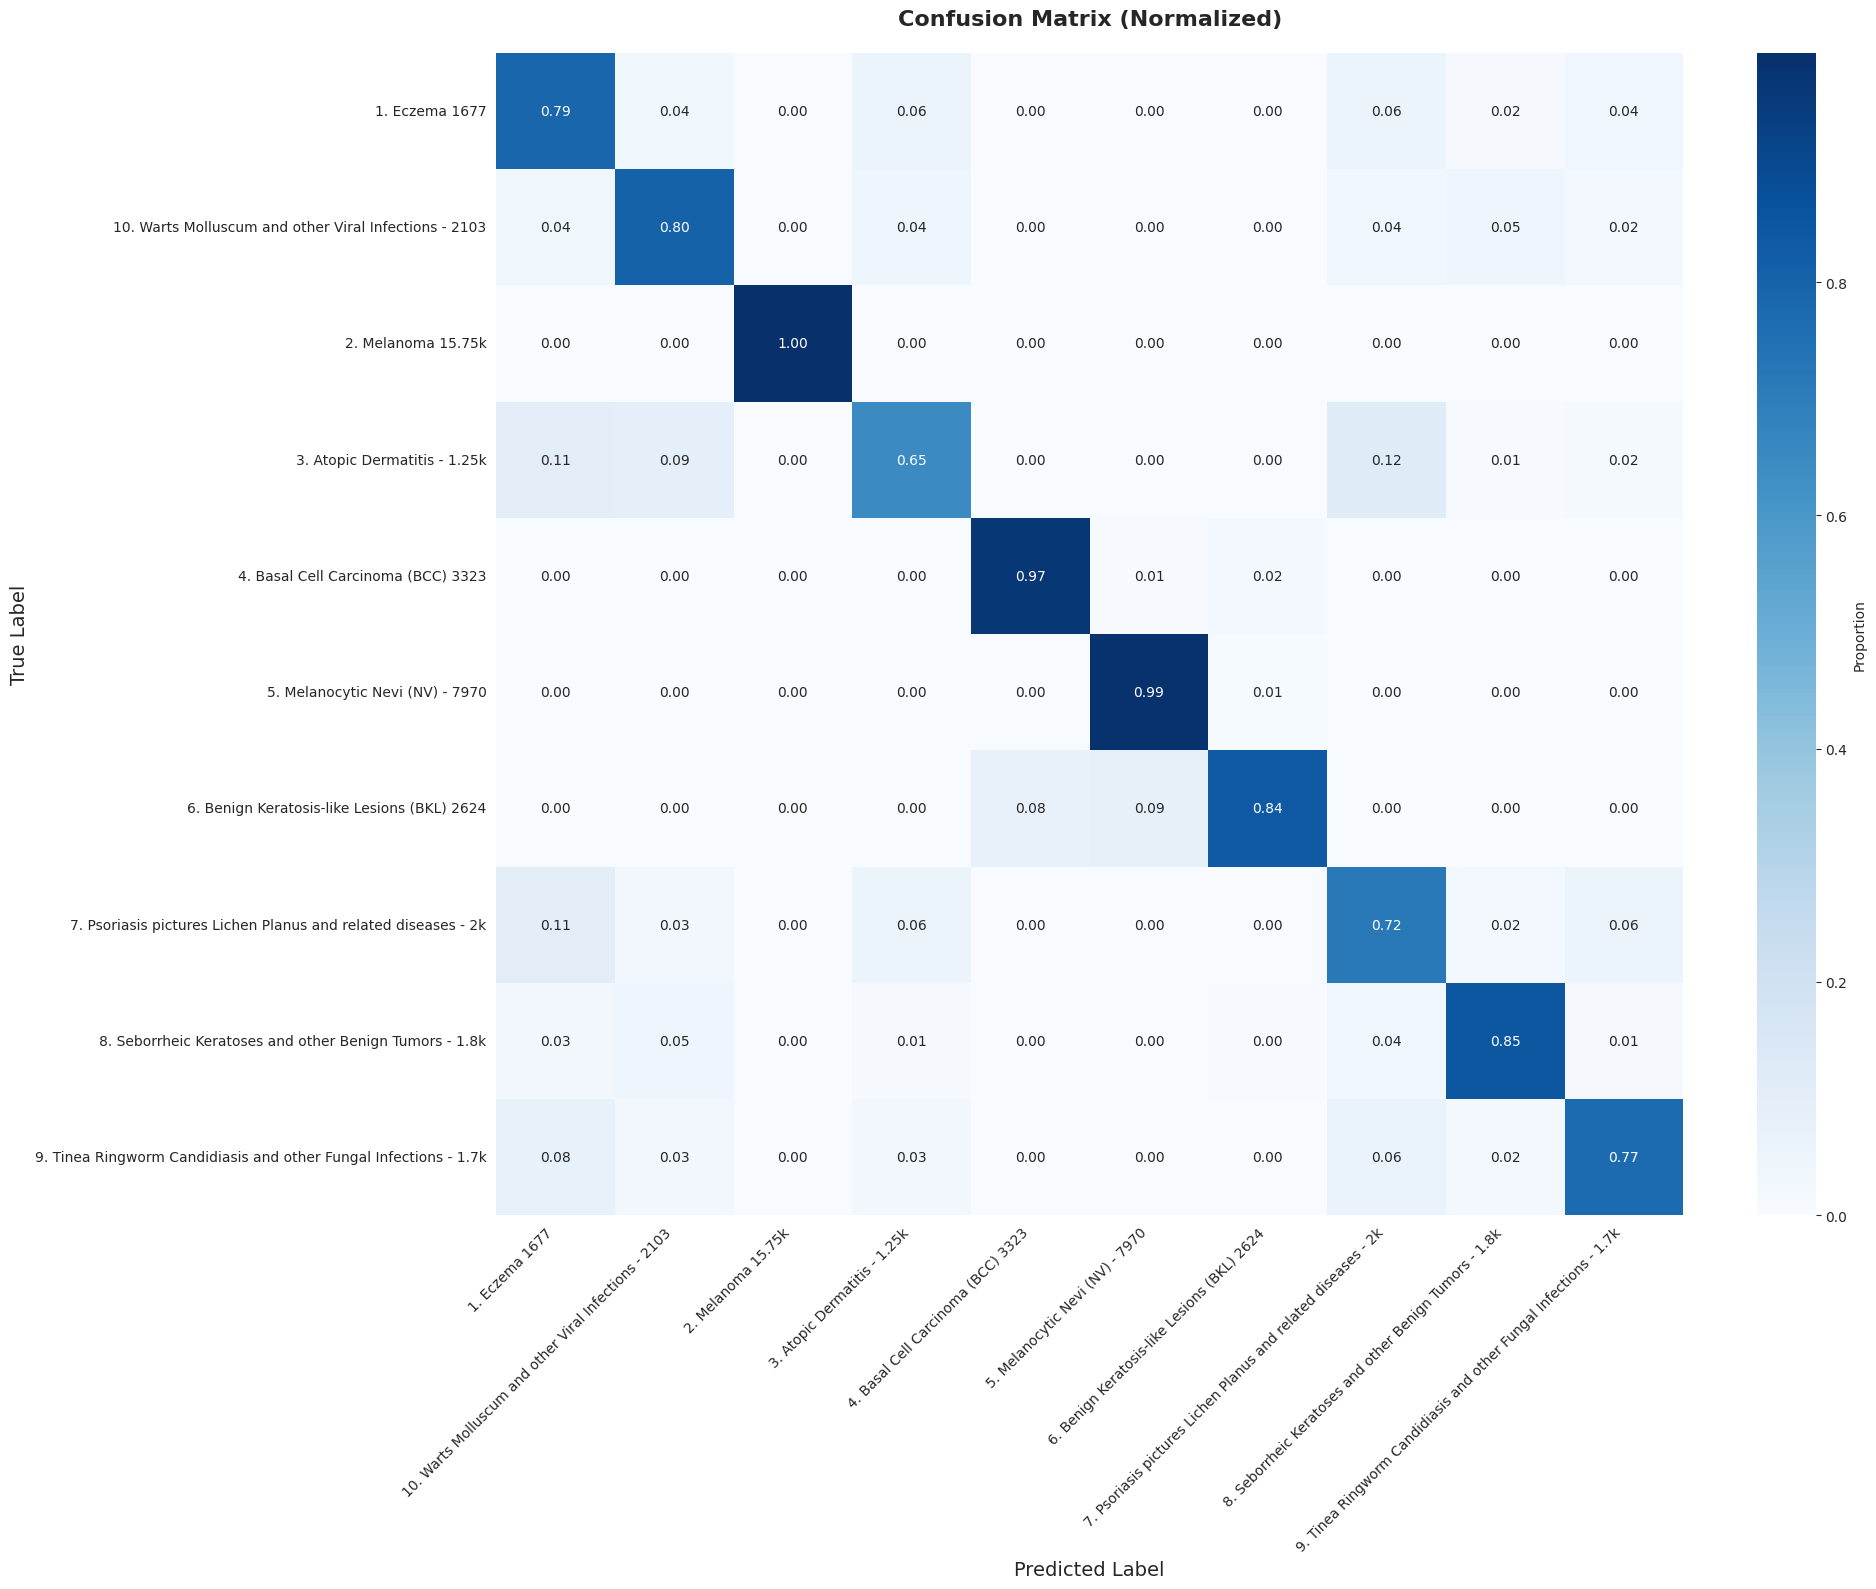

In [24]:
# Plot confusion matrix
plot_confusion_matrix(
    oof_targets,
    oof_pred_classes,
    class_names,
    save_path=f'{CFG.OUTPUT_DIR}/confusion_matrix.png'
)

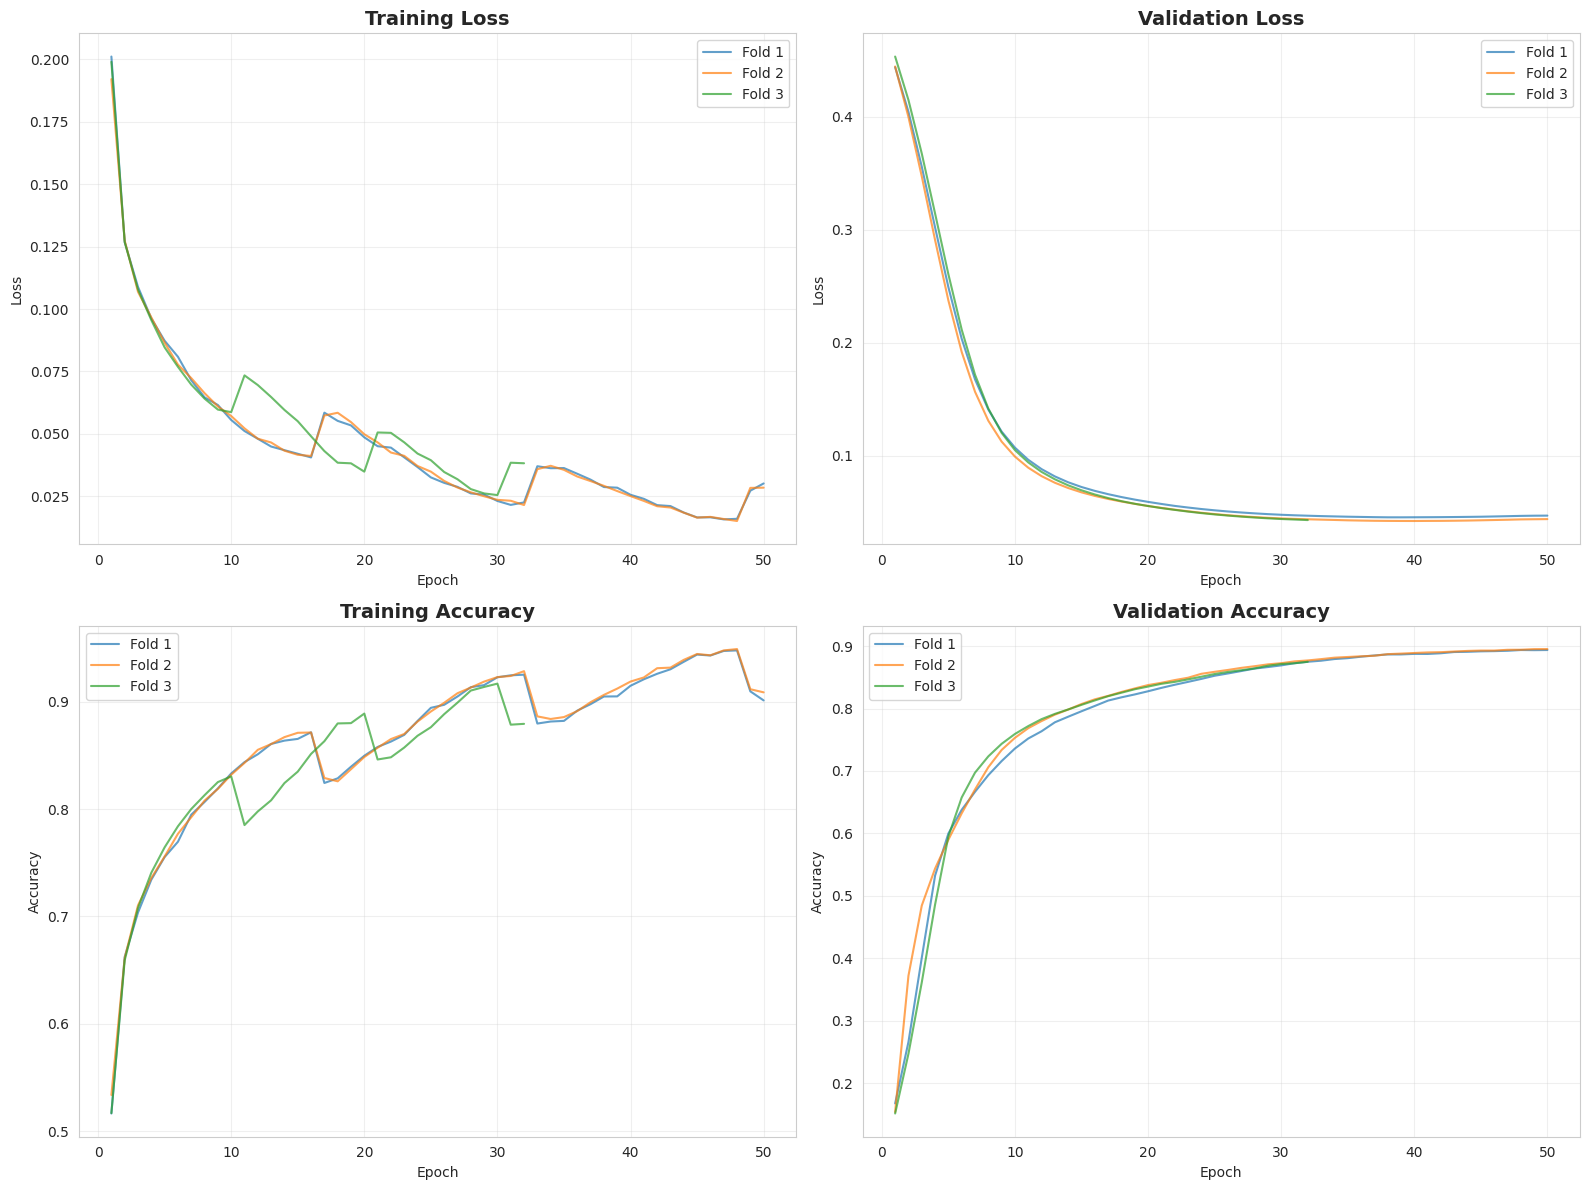

In [25]:
# Plot training history
plot_training_history(
    fold_results,
    save_path=f'{CFG.OUTPUT_DIR}/training_history.png'
)

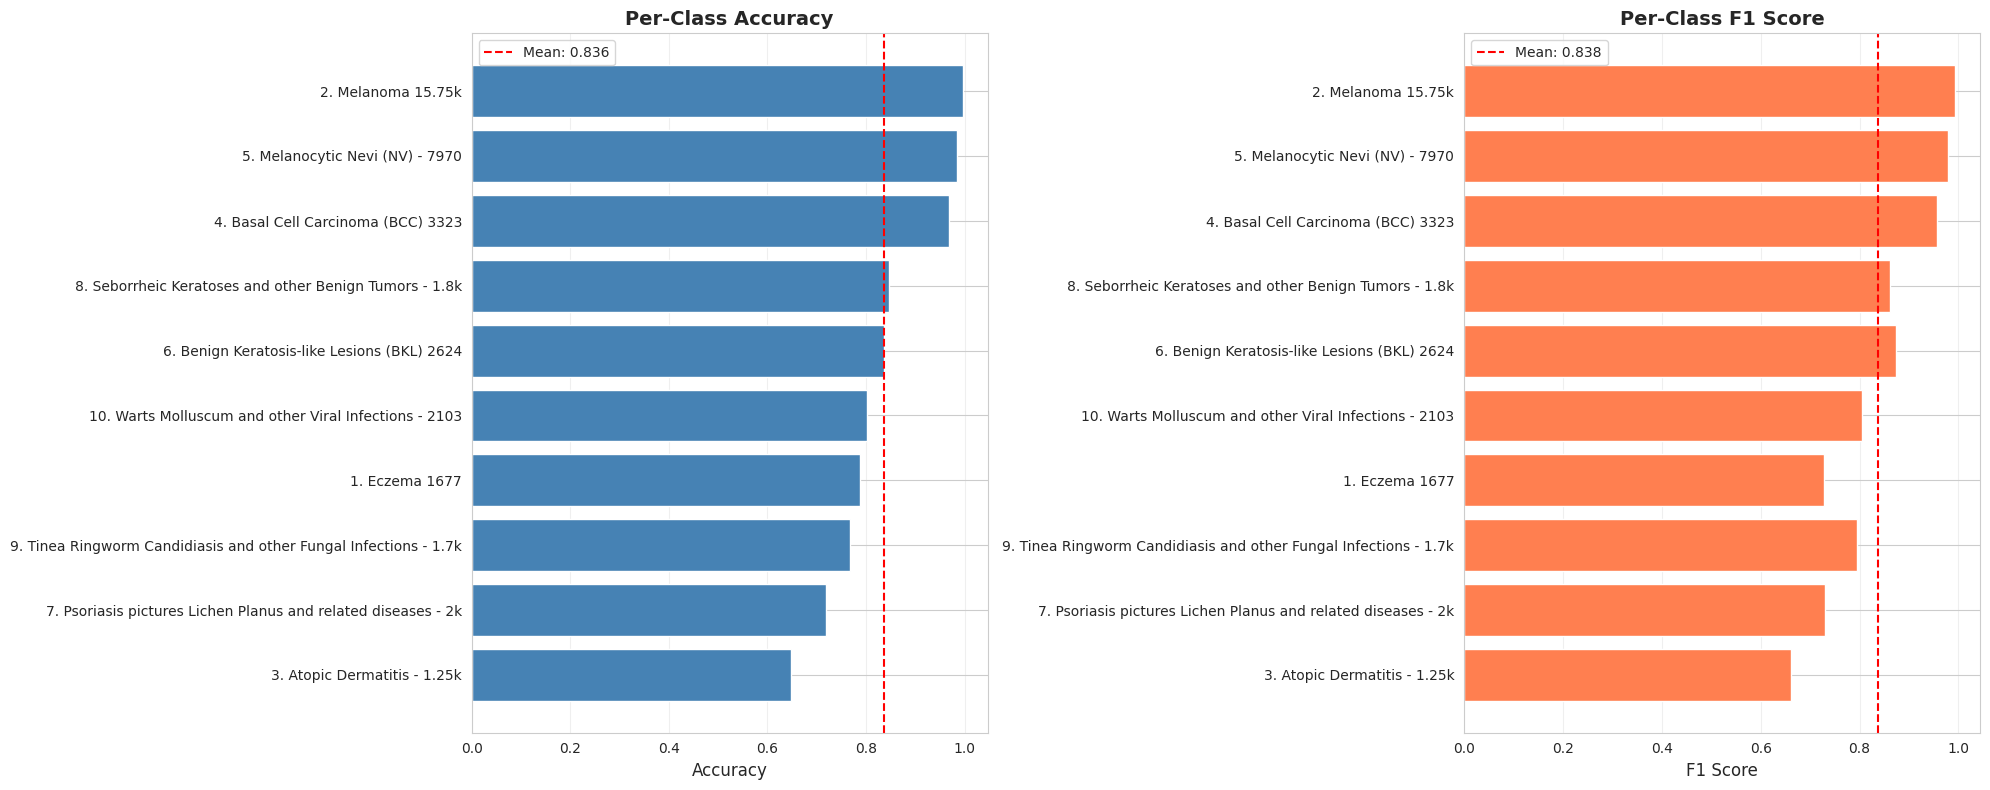


Per-Class Performance:
                                                           Class  Accuracy  F1-Score  Support
                                    3. Atopic Dermatitis - 1.25k  0.647574  0.660446     1257
   7. Psoriasis pictures Lichen Planus and related diseases - 2k  0.718248  0.729609     2055
9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k  0.767333  0.794404     1702
                                                  1. Eczema 1677  0.788312  0.727974     1677
           10. Warts Molluscum and other Viral Infections - 2103  0.802663  0.804192     2103
                     6. Benign Keratosis-like Lesions (BKL) 2624  0.836460  0.873869     2079
          8. Seborrheic Keratoses and other Benign Tumors - 1.8k  0.846779  0.861471     1847
                              4. Basal Cell Carcinoma (BCC) 3323  0.968703  0.956612     3323
                                 5. Melanocytic Nevi (NV) - 7970  0.985320  0.979238     7970
                                    

In [26]:
# Plot per-class metrics
metrics_df = plot_per_class_metrics(
    oof_targets,
    oof_pred_classes,
    class_names,
    save_path=f'{CFG.OUTPUT_DIR}/per_class_metrics.png'
)

print("\nPer-Class Performance:")
print(metrics_df.to_string(index=False))

# Identify weakest classes
print("\n⚠️  Weakest 3 Classes:")
for idx, row in metrics_df.head(3).iterrows():
    print(f"  {row['Class']}: Acc={row['Accuracy']:.3f}, F1={row['F1-Score']:.3f}, Support={int(row['Support'])}")

## 💾 17. Save Results

In [27]:
# Save OOF predictions
oof_df = df.copy()
oof_df['oof_prediction'] = oof_pred_classes
oof_df['oof_correct'] = (oof_df['label'] == oof_df['oof_prediction']).astype(int)

# Add probability columns
for i, class_name in enumerate(class_names):
    oof_df[f'prob_{class_name}'] = oof_predictions[:, i]

oof_df.to_csv(f'{CFG.OUTPUT_DIR}/oof_predictions.csv', index=False)
print(f"✓ OOF predictions saved to {CFG.OUTPUT_DIR}/oof_predictions.csv")

# Save fold results
fold_results_df = pd.DataFrame([
    {
        'fold': r['fold'],
        'best_accuracy': r['best_acc'],
        'best_epoch': r['best_epoch']
    }
    for r in fold_results
])
fold_results_df.to_csv(f'{CFG.OUTPUT_DIR}/fold_results.csv', index=False)
print(f"✓ Fold results saved to {CFG.OUTPUT_DIR}/fold_results.csv")

# Save config
config_dict = {k: v for k, v in CFG.__dict__.items() if not k.startswith('_')}
config_dict['CLASS_NAMES'] = class_names
config_dict['CLASS_WEIGHTS'] = CFG.CLASS_WEIGHTS.tolist()
config_dict['TRAIN_FOLDS'] = CFG.TRAIN_FOLDS

with open(f'{CFG.OUTPUT_DIR}/config.json', 'w') as f:
    json.dump(config_dict, f, indent=4)
print(f"✓ Configuration saved to {CFG.OUTPUT_DIR}/config.json")

# Save numpy arrays
np.save(f'{CFG.OUTPUT_DIR}/oof_predictions.npy', oof_predictions)
np.save(f'{CFG.OUTPUT_DIR}/oof_targets.npy', oof_targets)
print(f"✓ NumPy arrays saved")

✓ OOF predictions saved to ./outputs/oof_predictions.csv
✓ Fold results saved to ./outputs/fold_results.csv
✓ Configuration saved to ./outputs/config.json
✓ NumPy arrays saved


## 🎯 18. Final Summary & Next Steps

In [28]:
# Final training summary
print("\n" + "="*70)
print("📊 FINAL TRAINING SUMMARY")
print("="*70)

print(f"\n🎯 Model Configuration:")
print(f"   Backbone: {CFG.BACKBONE}")
print(f"   Image Size: {CFG.IMG_SIZE}x{CFG.IMG_SIZE}")
print(f"   Number of Classes: {CFG.NUM_CLASSES}")
print(f"   Batch Size: {CFG.EFFECTIVE_BATCH_SIZE}")
print(f"   Epochs Trained: {CFG.EPOCHS}")

print(f"\n📈 Performance Metrics:")
print(f"   OOF Accuracy: {oof_acc:.4f} ({oof_acc*100:.2f}%)")
print(f"   OOF F1-Score: {oof_f1:.4f}")
print(f"   OOF Balanced Accuracy: {oof_balanced_acc:.4f}")
print(f"   OOF ECE: {oof_ece:.4f}")

if fold_results:
    fold_accs = [r['best_acc'] for r in fold_results]
    print(f"\n🔄 Cross-Validation:")
    print(f"   Number of Folds: {len(fold_results)}")
    print(f"   Mean Accuracy: {np.mean(fold_accs):.4f}")
    print(f"   Std Accuracy: {np.std(fold_accs):.4f}")
    print(f"   Best Fold: {np.argmax(fold_accs)} ({np.max(fold_accs):.4f})")
    print(f"   Worst Fold: {np.argmin(fold_accs)} ({np.min(fold_accs):.4f})")

print(f"\n💾 Saved Outputs:")
print(f"   Output Directory: {CFG.OUTPUT_DIR}")
print(f"   Model Checkpoints: {len([f for f in os.listdir(CFG.OUTPUT_DIR) if f.endswith('.pth')])} files")
print(f"   Visualizations: {len([f for f in os.listdir(CFG.OUTPUT_DIR) if f.endswith('.png')])} plots")
print(f"   CSV Reports: {len([f for f in os.listdir(CFG.OUTPUT_DIR) if f.endswith('.csv')])} files")

print(f"\n🎓 Achievement Level:")
if oof_acc >= 0.95:
    print(f"   ⭐⭐⭐⭐⭐ OUTSTANDING! (95%+)")
elif oof_acc >= 0.90:
    print(f"   ⭐⭐⭐⭐ EXCELLENT! (90-95%)")
elif oof_acc >= 0.85:
    print(f"   ⭐⭐⭐ VERY GOOD! (85-90%)")
elif oof_acc >= 0.80:
    print(f"   ⭐⭐ GOOD! (80-85%)")
else:
    print(f"   ⭐ BASELINE (80%-)")

print("\n" + "="*70)

# Save summary to text file
summary_file = f'{CFG.OUTPUT_DIR}/training_summary.txt'
with open(summary_file, 'w') as f:
    f.write("="*70 + "\n")
    f.write("TRAINING SUMMARY\n")
    f.write("="*70 + "\n\n")
    f.write(f"Backbone: {CFG.BACKBONE}\n")
    f.write(f"Image Size: {CFG.IMG_SIZE}x{CFG.IMG_SIZE}\n")
    f.write(f"Number of Classes: {CFG.NUM_CLASSES}\n")
    f.write(f"Epochs: {CFG.EPOCHS}\n\n")
    f.write(f"OOF Accuracy: {oof_acc:.4f} ({oof_acc*100:.2f}%)\n")
    f.write(f"OOF F1-Score: {oof_f1:.4f}\n")
    f.write(f"OOF Balanced Accuracy: {oof_balanced_acc:.4f}\n")
    f.write(f"OOF ECE: {oof_ece:.4f}\n")

print(f"\n✓ Summary saved to: {summary_file}")


📊 FINAL TRAINING SUMMARY

🎯 Model Configuration:
   Backbone: convnext_small.fb_in22k_ft_in1k
   Image Size: 256x256
   Number of Classes: 10
   Batch Size: 32
   Epochs Trained: 50

📈 Performance Metrics:
   OOF Accuracy: 0.8879 (88.79%)
   OOF F1-Score: 0.8382
   OOF Balanced Accuracy: 0.8358
   OOF ECE: 0.0408

🔄 Cross-Validation:
   Number of Folds: 3
   Mean Accuracy: 0.8879
   Std Accuracy: 0.0093
   Best Fold: 1 (0.8953)
   Worst Fold: 2 (0.8748)

💾 Saved Outputs:
   Output Directory: ./outputs
   Model Checkpoints: 3 files
   Visualizations: 4 plots
   CSV Reports: 2 files

🎓 Achievement Level:
   ⭐⭐⭐ VERY GOOD! (85-90%)


✓ Summary saved to: ./outputs/training_summary.txt


## 🔮 19. BONUS: Simple Inference Example

In [29]:
# Simple ensemble inference function
@torch.no_grad()
def predict_image(image_path, models, transform, class_names, device):
    """Predict a single image using ensemble of models."""
    
    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Apply transform
    augmented = transform(image=image)
    img_tensor = augmented['image'].unsqueeze(0).to(device)
    
    # Get predictions from all models
    all_probs = []
    for model in models:
        model.eval()
        outputs = model(img_tensor)
        probs = F.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())
    
    # Average predictions
    mean_probs = np.mean(all_probs, axis=0)[0]
    
    # Get top prediction
    pred_class = np.argmax(mean_probs)
    confidence = mean_probs[pred_class]
    
    return {
        'class': class_names[pred_class],
        'confidence': confidence,
        'probabilities': {class_names[i]: mean_probs[i] for i in range(len(class_names))}
    }


# Load all fold models for inference
def load_ensemble_models(output_dir, config):
    """Load all trained fold models."""
    models = []
    
    for fold in range(config.N_FOLDS):
        checkpoint_path = f'{output_dir}/fold{fold}_best.pth'
        
        if os.path.exists(checkpoint_path):
            # Create model
            model = ImageClassifier(
                backbone=config.BACKBONE,
                num_classes=config.NUM_CLASSES,
                pretrained=False,
                use_gem=config.USE_GEM_POOLING,
                gem_p=config.GEM_P_INIT
            ).to(config.DEVICE)
            
            # Load checkpoint
            checkpoint = torch.load(checkpoint_path, map_location=config.DEVICE)
            model.load_state_dict(checkpoint['model_state_dict'])
            model.eval()
            
            models.append(model)
            print(f"✓ Loaded fold {fold} model")
    
    return models

print("✓ Inference functions defined")
print("\nTo use:")
print("  1. ensemble_models = load_ensemble_models(CFG.OUTPUT_DIR, CFG)")
print("  2. result = predict_image('path/to/image.jpg', ensemble_models, get_valid_transforms(CFG.IMG_SIZE), class_names, CFG.DEVICE)")
print("  3. print(result)")

✓ Inference functions defined

To use:
  1. ensemble_models = load_ensemble_models(CFG.OUTPUT_DIR, CFG)
  2. result = predict_image('path/to/image.jpg', ensemble_models, get_valid_transforms(CFG.IMG_SIZE), class_names, CFG.DEVICE)
  3. print(result)


## 📦 20. Backup Results for Kaggle

**Important for Kaggle users:**
- Kaggle automatically saves all files in `/kaggle/working/` to the Output tab
- You can also create a zip backup for easy download|
- The zip will appear in the **Output** tab on the right side →

In [30]:
# Check if we're running on Kaggle
import os
import shutil

is_kaggle = os.path.exists('/kaggle/working')

if is_kaggle:
    print("✓ Running on Kaggle")
    print(f"✓ Output directory: {CFG.OUTPUT_DIR}")
    print(f"✓ Files are automatically saved to Output tab")
else:
    print("ℹ️  Not running on Kaggle")
    print(f"✓ Output directory: {os.path.abspath(CFG.OUTPUT_DIR)}")

✓ Running on Kaggle
✓ Output directory: ./outputs
✓ Files are automatically saved to Output tab


In [31]:
# List all output files
print("\n" + "="*70)
print("📁 OUTPUT FILES")
print("="*70 + "\n")

if os.path.exists(CFG.OUTPUT_DIR):
    files = os.listdir(CFG.OUTPUT_DIR)
    
    total_size = 0
    for f in sorted(files):
        filepath = os.path.join(CFG.OUTPUT_DIR, f)
        if os.path.isfile(filepath):
            size = os.path.getsize(filepath)
            total_size += size
            size_mb = size / (1024 * 1024)
            print(f"  {f:<40} {size_mb:>8.2f} MB")
    
    print(f"\n  {'Total:':<40} {total_size / (1024 * 1024):>8.2f} MB")
    print(f"  {'Number of files:':<40} {len(files):>8}")
else:
    print(f"  ⚠️  Output directory not found: {CFG.OUTPUT_DIR}")

print("\n" + "="*70)


📁 OUTPUT FILES

  class_distribution.png                       0.20 MB
  config.json                                  0.00 MB
  confusion_matrix.png                         0.34 MB
  fold0_best.pth                             566.51 MB
  fold1_best.pth                             566.51 MB
  fold2_best.pth                             566.51 MB
  fold_results.csv                             0.00 MB
  oof_predictions.csv                         10.20 MB
  oof_predictions.npy                          2.07 MB
  oof_targets.npy                              0.21 MB
  per_class_metrics.png                        0.12 MB
  training_history.png                         0.24 MB
  training_summary.txt                         0.00 MB

  Total:                                    1712.92 MB
  Number of files:                               13



In [32]:
# Create backup zip file
print("\n" + "="*70)
print("📦 CREATING BACKUP ZIP")
print("="*70 + "\n")

zip_filename = 'outputs_backup.zip'

# Remove old zip if exists
if os.path.exists(zip_filename):
    os.remove(zip_filename)
    print(f"Removed old {zip_filename}")

# Create zip file
print(f"Creating {zip_filename}...")
!zip -r -q outputs_backup.zip {CFG.OUTPUT_DIR}/

# Check if successful
if os.path.exists(zip_filename):
    size_mb = os.path.getsize(zip_filename) / (1024 * 1024)
    print(f"\n✅ Backup created successfully!")
    print(f"   File: {zip_filename}")
    print(f"   Size: {size_mb:.2f} MB")
    print(f"   Location: {os.path.abspath(zip_filename)}")
    
    if is_kaggle:
        print(f"\n📥 TO DOWNLOAD:")
        print(f"   1. Look at the RIGHT side of this page")
        print(f"   2. Click the 'Output' tab")
        print(f"   3. Find '{zip_filename}'")
        print(f"   4. Click to download")
        print(f"\n💡 TIP: You can also download individual files from the Output tab")
    else:
        print(f"\n📥 Zip file ready at: {os.path.abspath(zip_filename)}")
else:
    print("\n❌ Failed to create zip file!")
    print("   Make sure the output directory exists and has files")

print("\n" + "="*70)


📦 CREATING BACKUP ZIP

Creating outputs_backup.zip...

✅ Backup created successfully!
   File: outputs_backup.zip
   Size: 1584.01 MB
   Location: /kaggle/working/outputs_backup.zip

📥 TO DOWNLOAD:
   1. Look at the RIGHT side of this page
   2. Click the 'Output' tab
   3. Find 'outputs_backup.zip'
   4. Click to download

💡 TIP: You can also download individual files from the Output tab



In [33]:
# Optional: Display download link (works in some Jupyter environments)
try:
    from IPython.display import FileLink, display
    
    if os.path.exists(zip_filename):
        print("\n📎 Download Link (click if available):")
        display(FileLink(zip_filename))
        print("\nℹ️  Note: Link may not work in all environments")
        print("   In Kaggle, use the Output tab instead")
except Exception as e:
    print(f"\nℹ️  Download link not available in this environment")
    print(f"   Use the Output tab to download files")


📎 Download Link (click if available):


/kaggle/working/outputs_backup.zip


ℹ️  Note: Link may not work in all environments
   In Kaggle, use the Output tab instead


## 📊 21. Training Summary & Final Stats

In [34]:
# Final training summary
print("\n" + "="*70)
print("📊 FINAL TRAINING SUMMARY")
print("="*70)

print(f"\n🎯 Model Configuration:")
print(f"   Backbone: {CFG.BACKBONE}")
print(f"   Image Size: {CFG.IMG_SIZE}x{CFG.IMG_SIZE}")
print(f"   Number of Classes: {CFG.NUM_CLASSES}")
print(f"   Batch Size: {CFG.EFFECTIVE_BATCH_SIZE}")
print(f"   Epochs Trained: {CFG.EPOCHS}")

print(f"\n📈 Performance Metrics:")
print(f"   OOF Accuracy: {oof_acc:.4f} ({oof_acc*100:.2f}%)")
print(f"   OOF F1-Score: {oof_f1:.4f}")
print(f"   OOF Balanced Accuracy: {oof_balanced_acc:.4f}")
print(f"   OOF ECE: {oof_ece:.4f}")

if fold_results:
    fold_accs = [r['best_acc'] for r in fold_results]
    print(f"\n🔄 Cross-Validation:")
    print(f"   Number of Folds: {len(fold_results)}")
    print(f"   Mean Accuracy: {np.mean(fold_accs):.4f}")
    print(f"   Std Accuracy: {np.std(fold_accs):.4f}")
    print(f"   Best Fold: {np.argmax(fold_accs)} ({np.max(fold_accs):.4f})")
    print(f"   Worst Fold: {np.argmin(fold_accs)} ({np.min(fold_accs):.4f})")

print(f"\n💾 Saved Outputs:")
print(f"   Output Directory: {CFG.OUTPUT_DIR}")
print(f"   Model Checkpoints: {len([f for f in os.listdir(CFG.OUTPUT_DIR) if f.endswith('.pth')])} files")
print(f"   Visualizations: {len([f for f in os.listdir(CFG.OUTPUT_DIR) if f.endswith('.png')])} plots")
print(f"   CSV Reports: {len([f for f in os.listdir(CFG.OUTPUT_DIR) if f.endswith('.csv')])} files")

print(f"\n🎓 Achievement Level:")
if oof_acc >= 0.95:
    print(f"   ⭐⭐⭐⭐⭐ OUTSTANDING! (95%+)")
elif oof_acc >= 0.90:
    print(f"   ⭐⭐⭐⭐ EXCELLENT! (90-95%)")
elif oof_acc >= 0.85:
    print(f"   ⭐⭐⭐ VERY GOOD! (85-90%)")
elif oof_acc >= 0.80:
    print(f"   ⭐⭐ GOOD! (80-85%)")
else:
    print(f"   ⭐ BASELINE (80%-)")

print("\n" + "="*70)

# Save summary to text file
summary_file = f'{CFG.OUTPUT_DIR}/training_summary.txt'
with open(summary_file, 'w') as f:
    f.write("="*70 + "\n")
    f.write("TRAINING SUMMARY\n")
    f.write("="*70 + "\n\n")
    f.write(f"Backbone: {CFG.BACKBONE}\n")
    f.write(f"Image Size: {CFG.IMG_SIZE}x{CFG.IMG_SIZE}\n")
    f.write(f"Number of Classes: {CFG.NUM_CLASSES}\n")
    f.write(f"Epochs: {CFG.EPOCHS}\n\n")
    f.write(f"OOF Accuracy: {oof_acc:.4f} ({oof_acc*100:.2f}%)\n")
    f.write(f"OOF F1-Score: {oof_f1:.4f}\n")
    f.write(f"OOF Balanced Accuracy: {oof_balanced_acc:.4f}\n")
    f.write(f"OOF ECE: {oof_ece:.4f}\n")

print(f"\n✓ Summary saved to: {summary_file}")


📊 FINAL TRAINING SUMMARY

🎯 Model Configuration:
   Backbone: convnext_small.fb_in22k_ft_in1k
   Image Size: 256x256
   Number of Classes: 10
   Batch Size: 32
   Epochs Trained: 50

📈 Performance Metrics:
   OOF Accuracy: 0.8879 (88.79%)
   OOF F1-Score: 0.8382
   OOF Balanced Accuracy: 0.8358
   OOF ECE: 0.0408

🔄 Cross-Validation:
   Number of Folds: 3
   Mean Accuracy: 0.8879
   Std Accuracy: 0.0093
   Best Fold: 1 (0.8953)
   Worst Fold: 2 (0.8748)

💾 Saved Outputs:
   Output Directory: ./outputs
   Model Checkpoints: 3 files
   Visualizations: 4 plots
   CSV Reports: 2 files

🎓 Achievement Level:
   ⭐⭐⭐ VERY GOOD! (85-90%)


✓ Summary saved to: ./outputs/training_summary.txt


## 🎊 Congratulations!

You've completed the production-grade CNN training pipeline!

### 📚 What You Built:
- ✅ Complete end-to-end training pipeline
- ✅ 5-fold cross-validation with stratification
- ✅ Advanced data augmentation
- ✅ State-of-the-art model architecture
- ✅ EMA for better convergence
- ✅ Mixed precision training
- ✅ Comprehensive evaluation metrics
- ✅ Beautiful visualizations
- ✅ Ready-to-use inference code

### 🚀 Next Steps:
1. Analyze your confusion matrix to identify problem classes
2. Try different hyperparameters (learning rate, image size, etc.)
3. Experiment with different backbones
4. Use the ensemble for production inference
5. Apply Test-Time Augmentation for extra boost

**Happy Training! 🎉**